In [1]:
##### To DO: EDA #####
# 1. Check for missing values
# 2. Summary statistics
# 3. Visualizations
# 4. Correlation analysis
# 5. Time series analysis
# 6. Anomaly detection
# 7. Feature engineering

In [2]:
## libraries
import os
from dotenv import load_dotenv
import pandas as pd
import psycopg2
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
# load .env file
load_dotenv()

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "name": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD")
}

connection = psycopg2.connect(
            database=DB_CONFIG["name"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"]
        )

## Query data from the database
data = pd.read_sql("SELECT * FROM public.weather_data_0001", connection)

In [4]:
data.columns

Index(['id', 'temperature', 'humidity', 'pressure', 'wind_speed',
       'wind_direction', 'beaufort', 'direction_code', 'timestamp', 'lux',
       'solar_radiation'],
      dtype='object')

In [5]:
data.head()

id  temperature  humidity  pressure  wind_speed  wind_direction  beaufort  \
0  1.0        27.09     71.31    997.33         0.0            24.0         0   
1  1.0        27.07     71.21    997.39         0.0           347.7         0   
2  1.0        27.05     71.43    997.50         0.4           323.4         1   
3  1.0        27.01     72.22    997.51         0.0           338.7         0   
4  1.0        27.01     72.10    997.51         0.0           341.6         0   

   direction_code                        timestamp   lux  solar_radiation  
0               1 2025-09-07 19:43:13.288523+00:00  0.19              0.0  
1              15 2025-09-07 19:48:14.288204+00:00  0.13              0.0  
2              14 2025-09-07 19:53:15.288207+00:00  0.19              0.0  
3              15 2025-09-07 19:58:16.297926+00:00  0.19              0.0  
4              15 2025-09-07 20:03:17.293114+00:00  0.19              0.0

In [6]:
data.direction_code.unique()

array([ 1, 15, 14,  0, 13,  2,  4, 12, 11,  8,  5,  9,  6,  3,  7, 10],
      dtype=int64)

In [7]:
import pandas as pd
import numpy as np

# ========================
# Base Feature Engineering
# ========================
def feature_engineering(data: pd.DataFrame, resample_freq: str = None, drop_columns = None) -> pd.DataFrame:
    if data is None:
        raise ValueError("Dataframe is None")
    
    if drop_columns is not None:
        data = data.drop(columns=drop_columns, errors='ignore')
        print(f"Dropped columns: {drop_columns}")

    data = data.copy()
    
    # Convert timestamp to datetime and adjust timezone if needed
    data['timestamp'] = pd.to_datetime(data['timestamp']) + pd.Timedelta(hours=3)
    
    # Sort by timestamp
    data = data.sort_values("timestamp").reset_index(drop=True)

    # ===== Wind components =====
    data["wd_rad"] = np.deg2rad(data["wind_direction"])
    data["wind_u"] = np.cos(data["wd_rad"]) * data["wind_speed"]
    data["wind_v"] = np.sin(data["wd_rad"]) * data["wind_speed"]


    # ===== Delta wind degree (geçmişe dayalı) =====
    for l in [1, 3, 6]:
        data[f"delta_wind_direction_{l}h"] = data["wind_direction"].diff(l)

    # Resample if requested
    if resample_freq is not None:
        data = data.set_index('timestamp').resample(resample_freq).mean().reset_index()

    
    # ===== Cyclic time features =====
    data['hour'] = data['timestamp'].dt.hour
    data['day'] = data['timestamp'].dt.day
    data['month'] = data['timestamp'].dt.month

    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    
    return data

# ========================
# Meteorological Features
# ========================
def add_meteo_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()

    # Dew point & Dew point depression
    data["dew_point"] = data["temperature"] - (100 - data["humidity"]) / 5.0
    data["dewpoint_dep"] = data["temperature"] - data["dew_point"]

    return data

# ========================
# Advanced Features
# ========================
def add_advanced_features_with_lags(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data = data.sort_values("timestamp")

    # ===== Rolling mean & std =====
    rolling_cols = ["temperature", "humidity", "pressure"]
    windows = [3, 6]  # saat
    for col in rolling_cols:
        for w in windows:
            data[f"{col}_rollmean_{w}h"] = data[col].rolling(window=w, min_periods=1).mean()
            data[f"{col}_rollstd_{w}h"] = data[col].rolling(window=w, min_periods=1).std().fillna(0)


    # ===== Interaction terms =====
    data["temp_dewpoint_interaction"] = data["temperature"] * data["dewpoint_dep"]
    data["wind_solar_interaction"] = data["wind_speed"] * data["solar_radiation"]

    return data


def generate_features(df: pd.DataFrame, rolling_windows=[3,6], lags=[1,2,3,6,12,24]) -> pd.DataFrame:
    """
    Feature engineering pipeline:
    - Wind components
    - Time cyclic features
    - Delta features (farklar)
    - Lag features (geçmiş değerler)
    - Rolling mean/std
    - Interaction terms
    - Wind direction categories
    """
    data = df.copy()
    data = data.sort_values("timestamp").reset_index(drop=True)
    
    # ===== Delta features (differences) =====
    delta_cols = ["temperature", "humidity", "pressure", "wind_speed", "lux", "solar_radiation"]
    for col in delta_cols:
        for l in lags:
            data[f"delta_{col}_{l}h"] = data[col] - data[col].shift(l)

    # ===== Lag features (shifted past values) =====
    for col in delta_cols:
        for l in lags:
            data[f"lag_{col}_{l}h"] = data[col].shift(l)

    # ===== Rolling mean & std =====
    rolling_cols = ["temperature", "humidity", "pressure"]
    for col in rolling_cols:
        for w in rolling_windows:
            data[f"{col}_rollmean_{w}h"] = data[col].rolling(window=w, min_periods=1).mean()
            data[f"{col}_rollstd_{w}h"] = data[col].rolling(window=w, min_periods=1).std().fillna(0)

    # ===== Interaction terms =====
    data["temp_dewpoint_interaction"] = data["temperature"] * data["dewpoint_dep"]
    data["wind_solar_interaction"] = data["wind_speed"] * data["solar_radiation"]

    # ===== Wind direction categories (8 bins) =====
    bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    labels = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    data["wind_dir_cat"] = pd.cut(data["wind_direction"] % 360, bins=bins, labels=labels, right=False)

    # ===== Delta wind direction =====
    for l in [1, 3, 6]:
        data[f"delta_wind_direction_{l}h"] = data["wind_direction"].diff(l)

    return data


In [9]:
data = feature_engineering(data, drop_columns=["id"], resample_freq="H")
data = add_meteo_features(data)
data = add_advanced_features_with_lags(data)
data = generate_features(data)

Dropped columns: ['id']


In [11]:
## 2-Summary statistics
summary_stats = data.describe()
print("Summary statistics:")
summary_stats.T

Summary statistics:


count         mean        std       min         25%  \
temperature              353.0    29.020940   3.541076   21.7475   26.291667   
humidity                 353.0    45.768545  15.505218   20.9875   32.927500   
pressure                 353.0  1000.041032   2.266360  995.1550  998.360000   
wind_speed               353.0     0.466695   0.620890    0.0000    0.061538   
wind_direction           353.0   236.132602  60.753420   46.3000  198.766667   
...                        ...          ...        ...       ...         ...   
lag_solar_radiation_2h   351.0    27.242742  31.112188    0.0000    0.000000   
lag_solar_radiation_3h   350.0    27.143781  31.101359    0.0000    0.000000   
lag_solar_radiation_6h   347.0    27.008398  31.199587    0.0000    0.000000   
lag_solar_radiation_12h  341.0    27.348145  31.333703    0.0000    0.000000   
lag_solar_radiation_24h  329.0    27.717390  31.399478    0.0000    0.000000   

                                50%          75%          max  
temperature               28.275833    32.179167    37.101667  
humidity                  44.185714    58.620833    78.612500  
pressure                 999.851667  1001.168333  1005.721667  
wind_speed                 0.223077     0.600000     3.258333  
wind_direction           246.915385   278.816667   349.583333  
...                             ...          ...          ...  
lag_solar_radiation_2h     3.647500    53.969583    94.878333  
lag_solar_radiation_3h     3.365000    53.576875    94.878333  
lag_solar_radiation_6h     2.596667    53.969583    94.878333  
lag_solar_radiation_12h    3.082500    54.846923    94.878333  
lag_solar_radiation_24h    3.762500    55.848333    94.878333  

[112 rows x 8 columns]

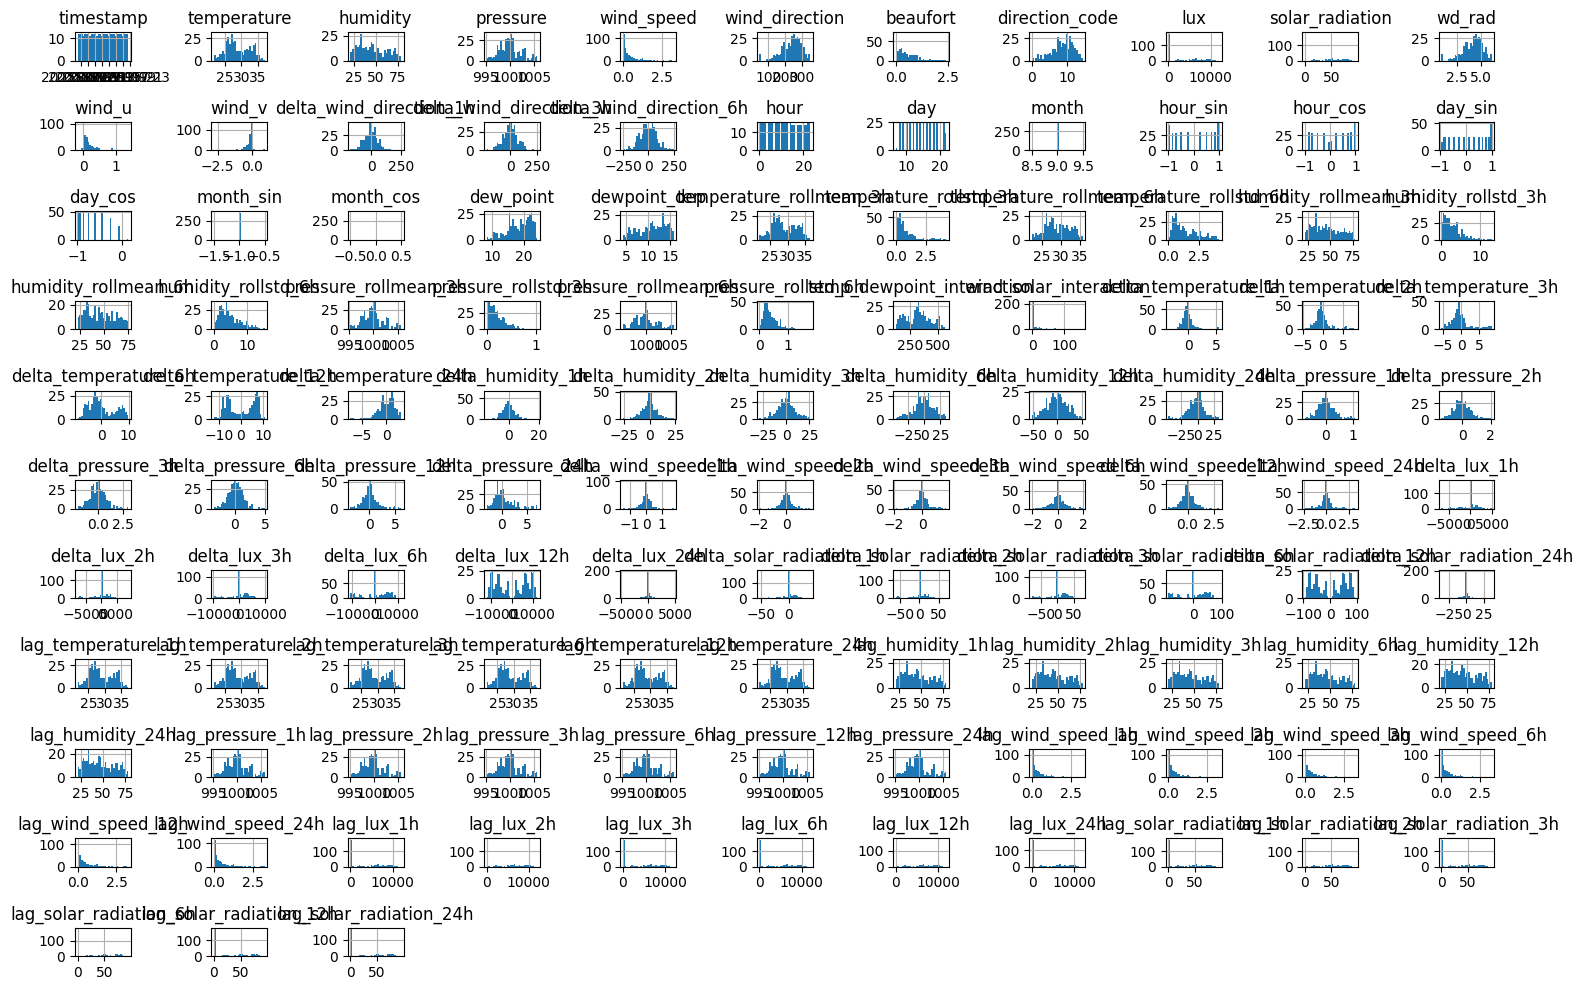

ValueError: num must be 1 <= num <= 9, not 10

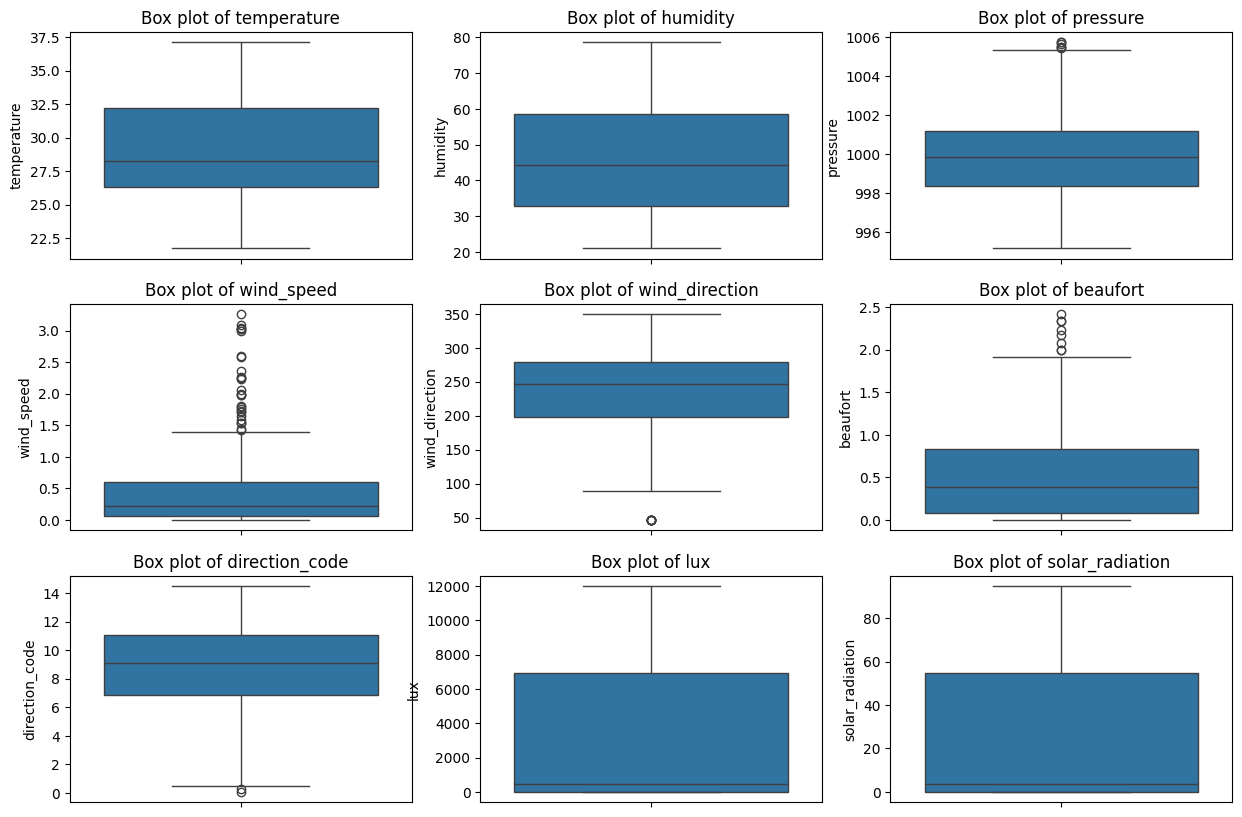

In [12]:
## 3-Visualizations

numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

import matplotlib.pyplot as plt
import seaborn as sns
# Multiple histograms
data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()
# Box plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=data[column])
    plt.title(f'Box plot of {column}')
plt.tight_layout()
plt.show()

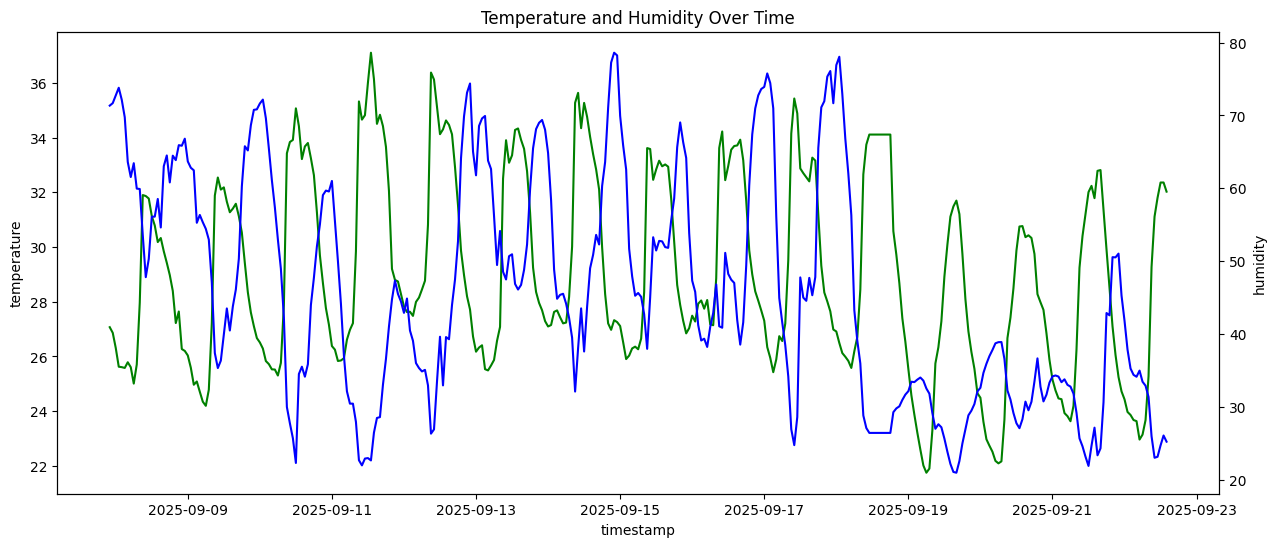

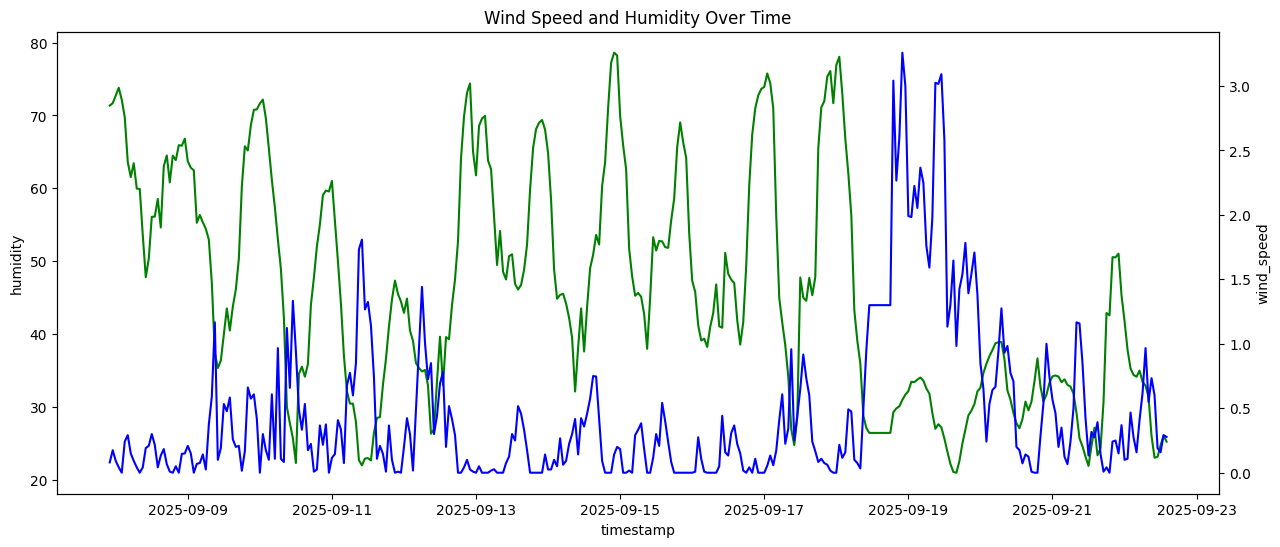

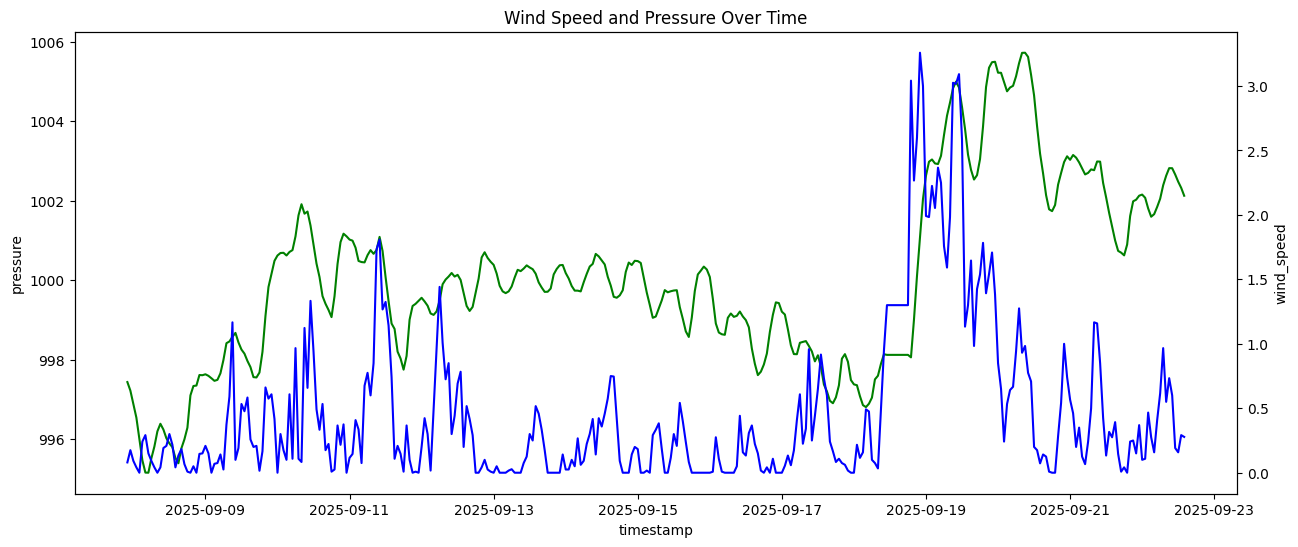

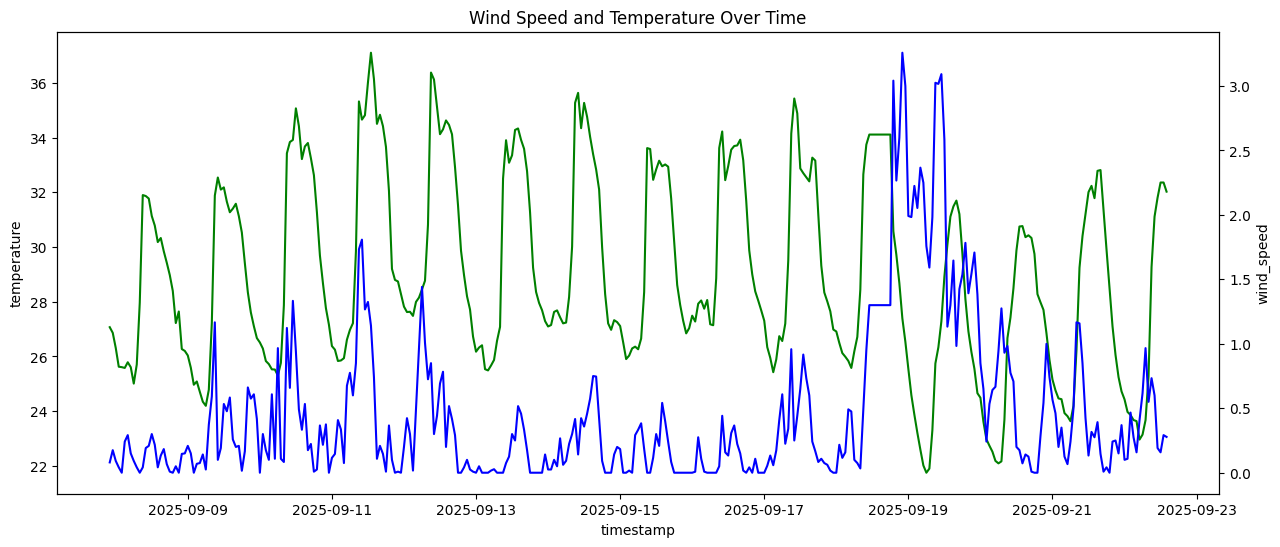

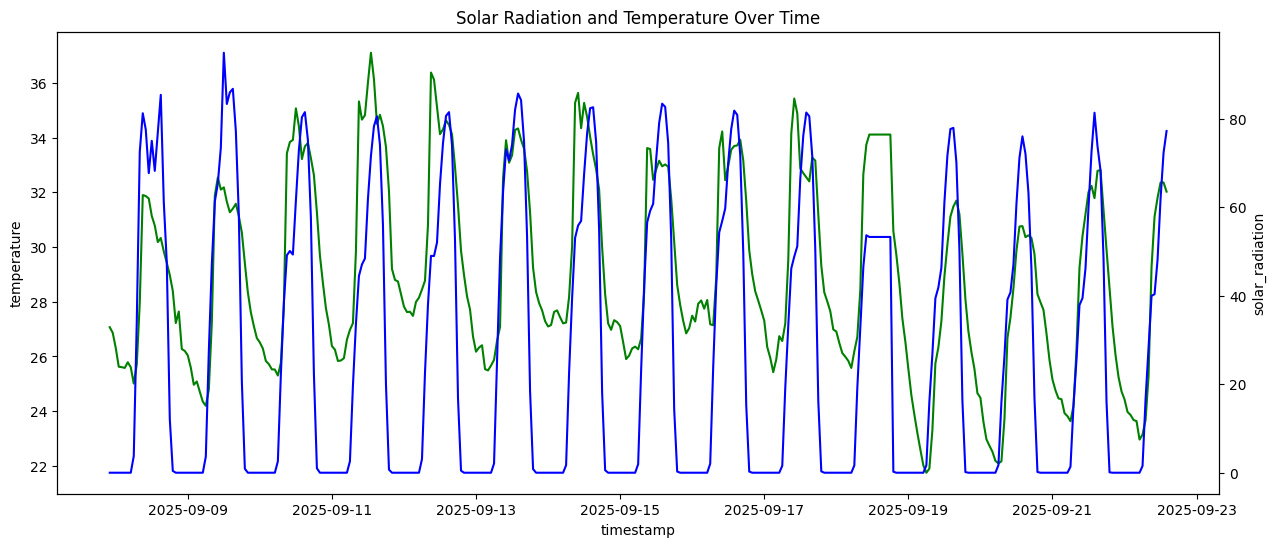

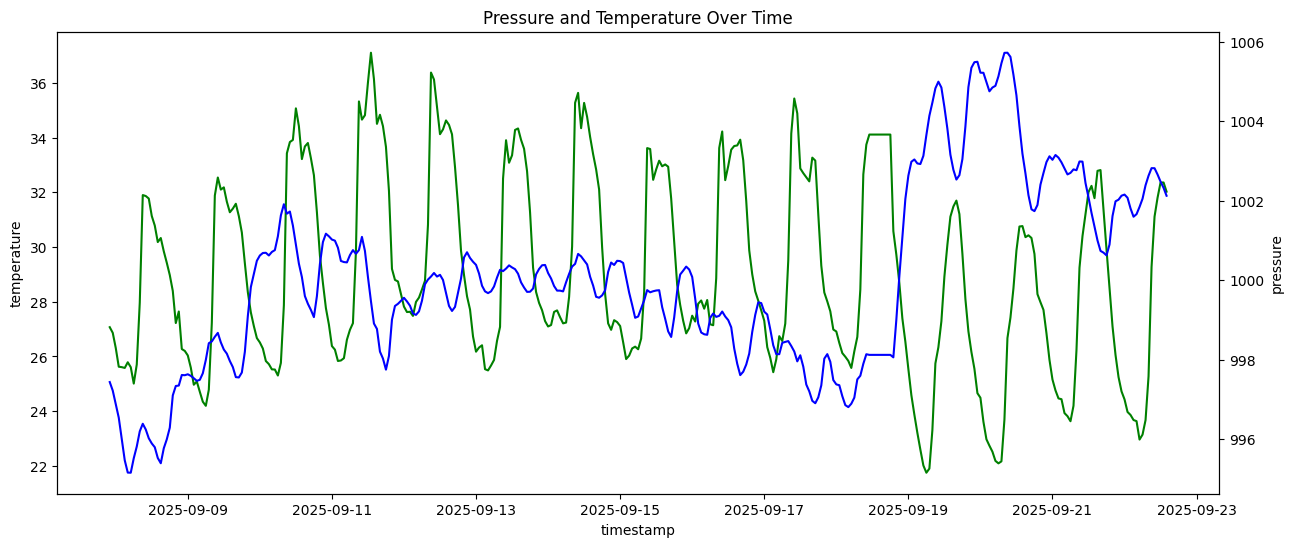

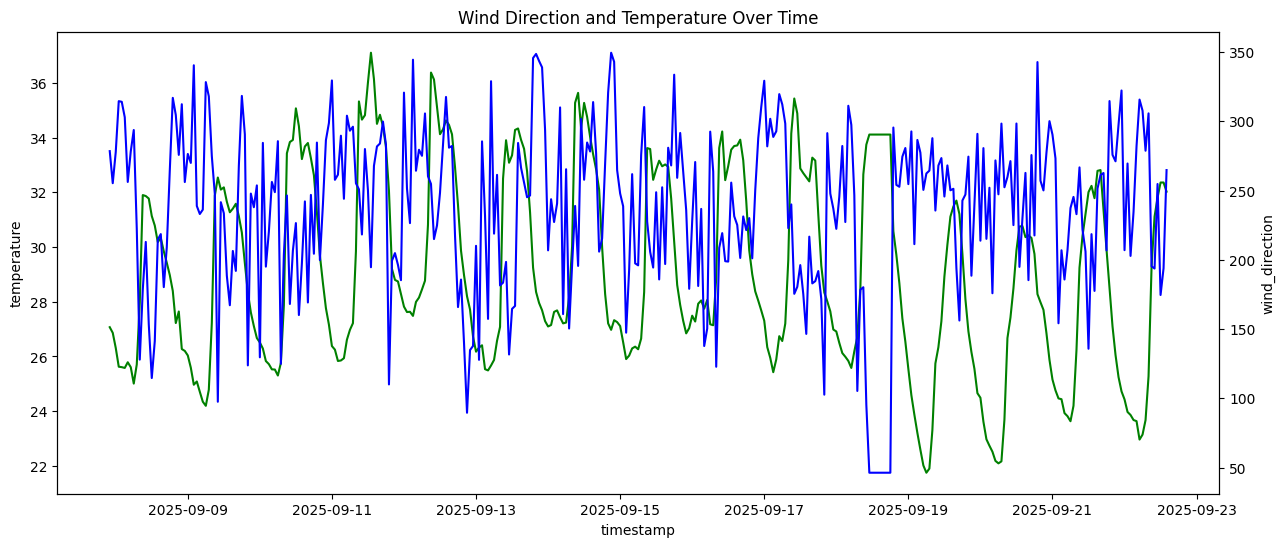

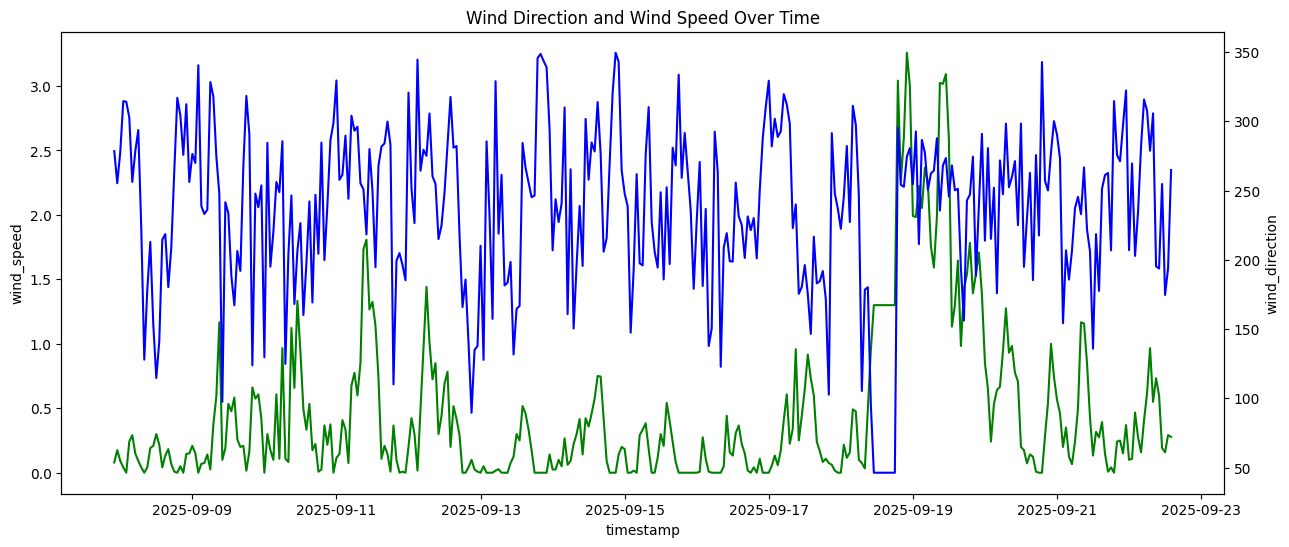

In [13]:
## Temporal trends two axis line plot
### Temperature and Humidity Over Time
plt.figure(figsize=(15, 6))
plt.title("Temperature and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="humidity", color="b", ax=ax2)
plt.show()

### Wind Speed and Precipitation Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Humidity Over Time")
sns.lineplot(data=data,x="timestamp",y="humidity",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Wind Speed and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Pressure Over Time")
sns.lineplot(data=data,x="timestamp",y="pressure",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()

### Temperature and Wind Speed Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Speed and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_speed", color="b", ax=ax2)
plt.show()


### Temperature and Solar Radiation Over Time
plt.figure(figsize=(15, 6))
plt.title("Solar Radiation and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="solar_radiation", color="b", ax=ax2)
plt.show()


### Temperature and Pressure Over Time
plt.figure(figsize=(15, 6))
plt.title("Pressure and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="pressure", color="b", ax=ax2)
plt.show()

### Temperature and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

### Wind Speed and Wind Direction Over Time
plt.figure(figsize=(15, 6))
plt.title("Wind Direction and Wind Speed Over Time")
sns.lineplot(data=data,x="timestamp",y="wind_speed",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction", color="b", ax=ax2)
plt.show()

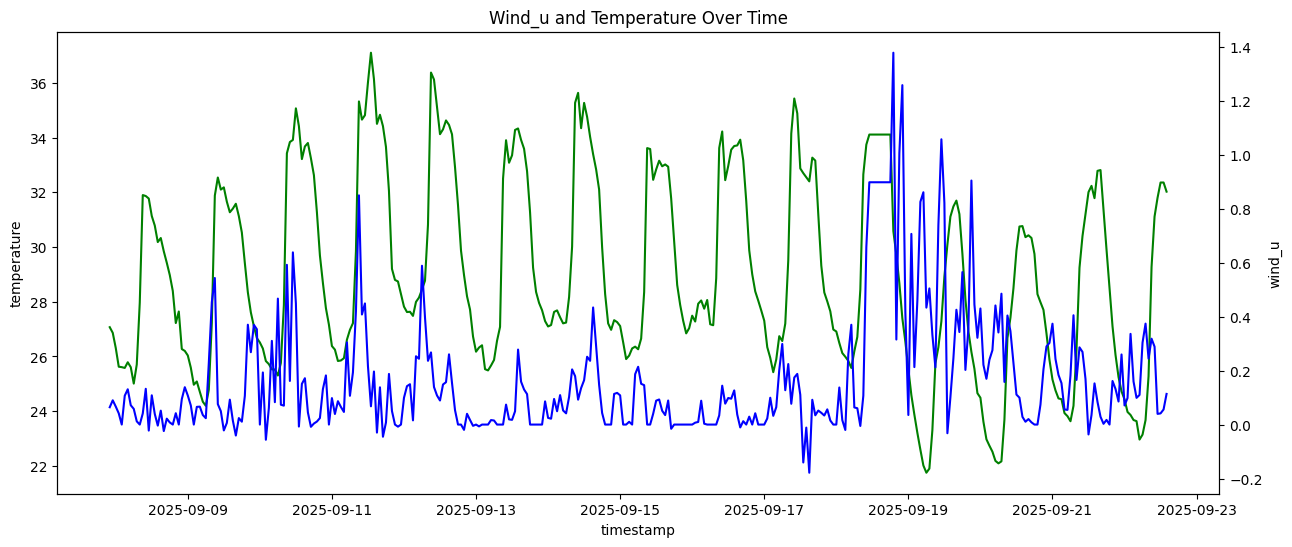

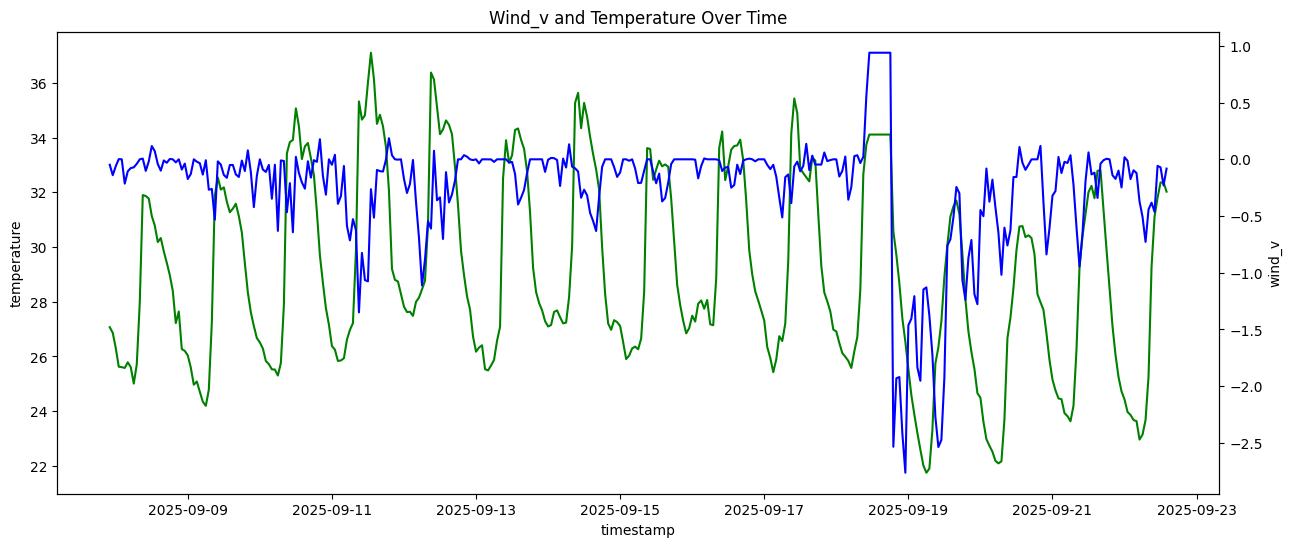

In [14]:
## temperature and wind_u
plt.figure(figsize=(15, 6))
plt.title("Wind_u and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_u", color="b", ax=ax2)
plt.show()


## temperature and wind_v
plt.figure(figsize=(15, 6))
plt.title("Wind_v and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_v", color="b", ax=ax2)
plt.show()

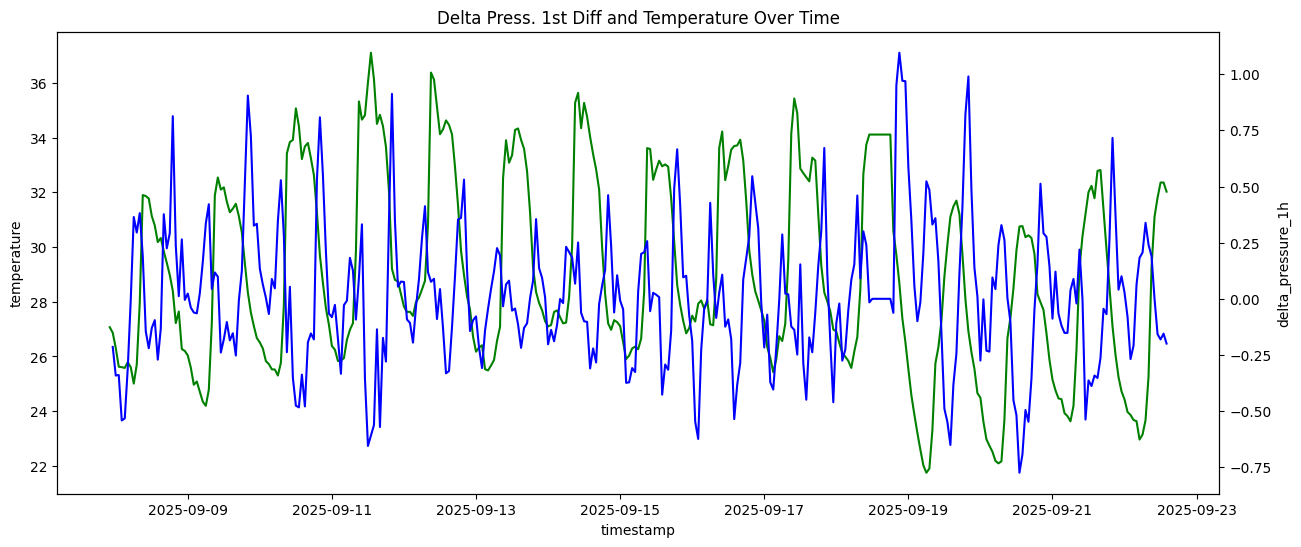

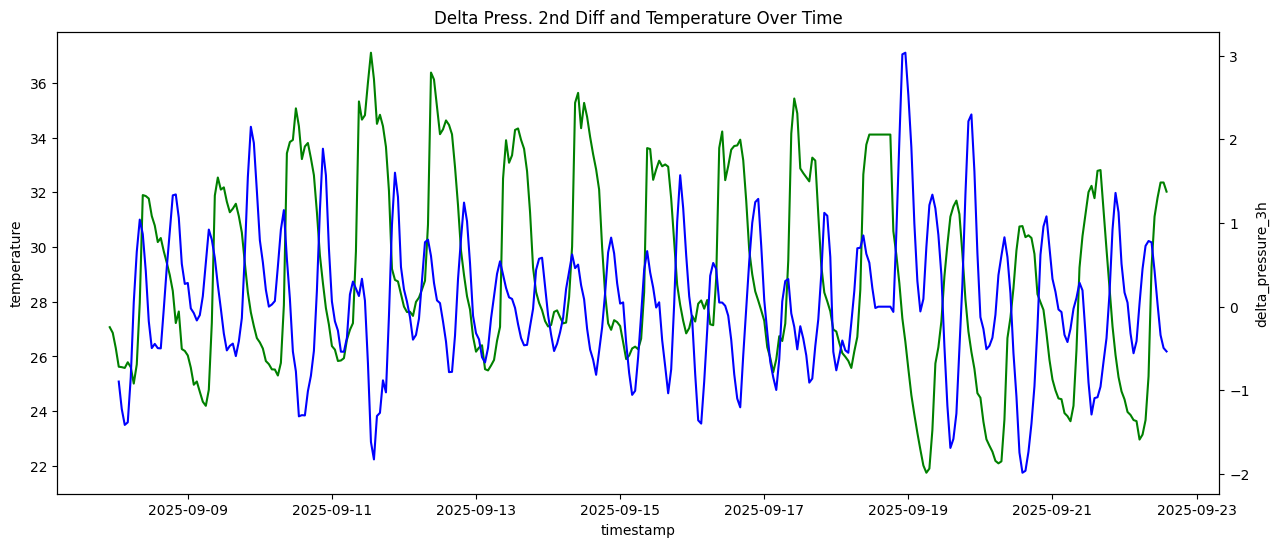

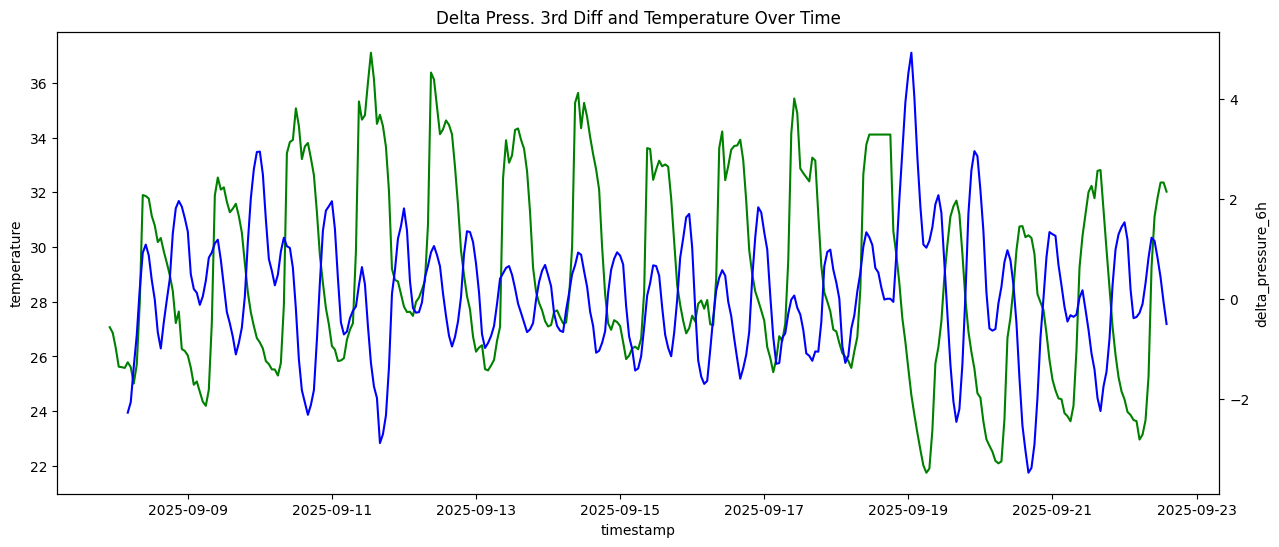

ValueError: Could not interpret value `wind_direction_code` for `y`. An entry with this name does not appear in `data`.

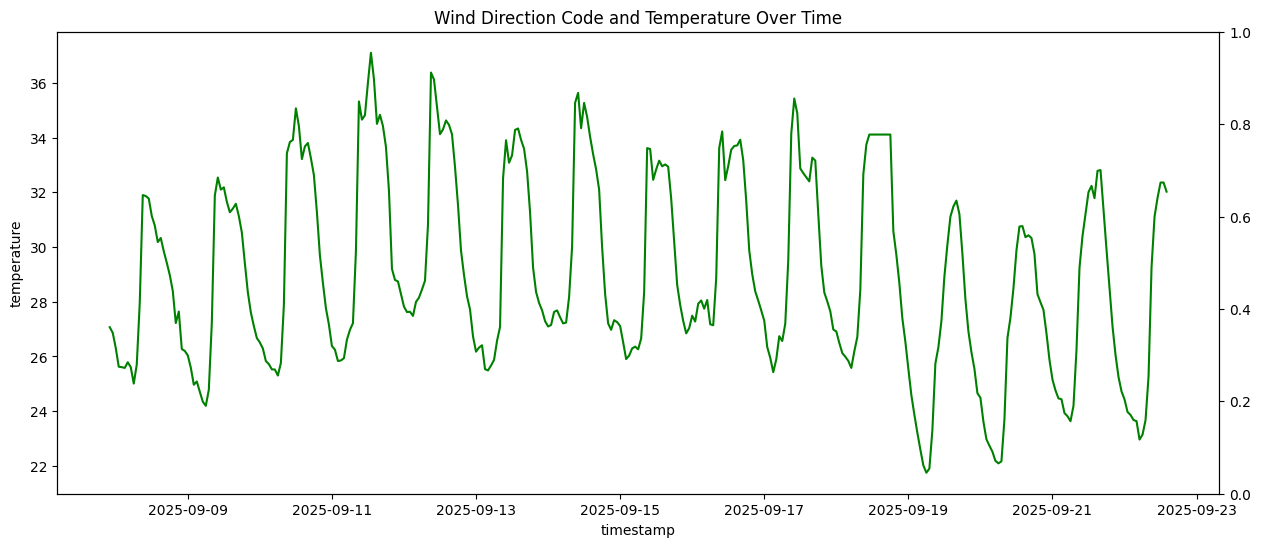

In [17]:
## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 1st Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_1h", color="b", ax=ax2)
plt.show()

## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 2nd Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_3h", color="b", ax=ax2)
plt.show()

## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Delta Press. 3rd Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_pressure_6h", color="b", ax=ax2)
plt.show()

## temperature and delta pressure
plt.figure(figsize=(15, 6))
plt.title("Wind Direction Code and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="wind_direction_code", color="b", ax=ax2)
plt.show()


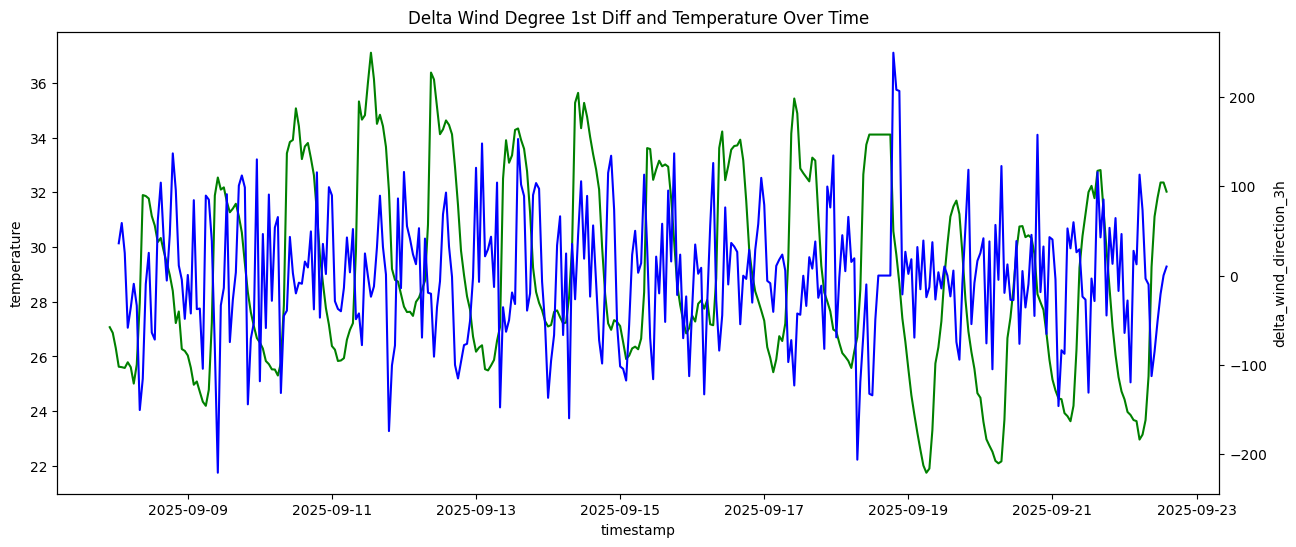

In [19]:
## temperature and wind degree delta
plt.figure(figsize=(15, 6))
plt.title("Delta Wind Degree 1st Diff and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="delta_wind_direction_3h", color="b", ax=ax2)
plt.show()

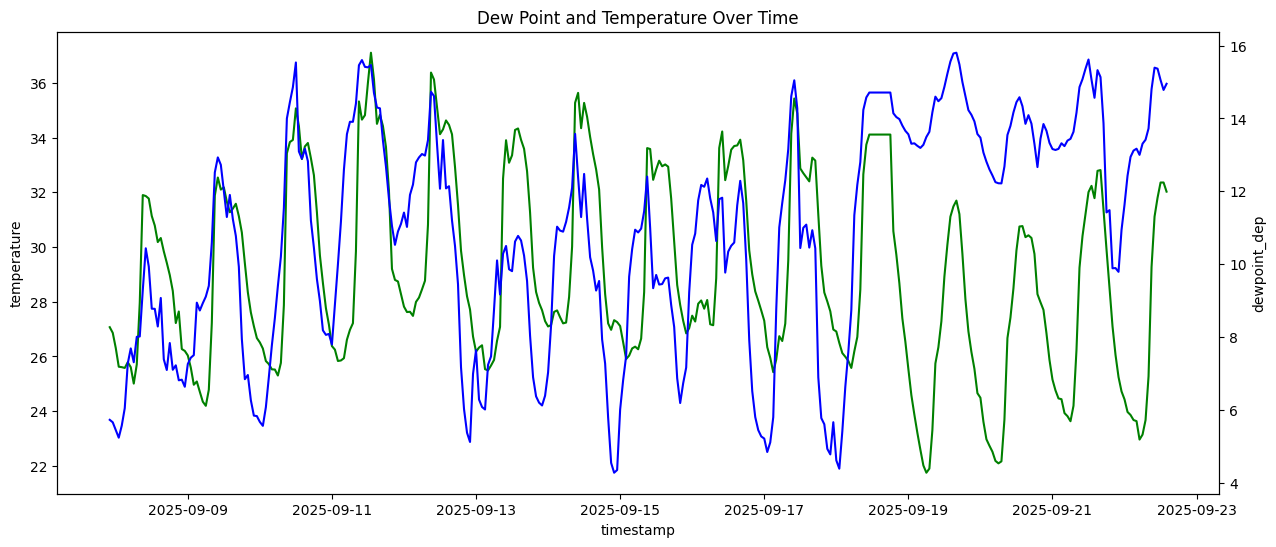

In [20]:
## temperature and dew point
plt.figure(figsize=(15, 6))
plt.title("Dew Point and Temperature Over Time")
sns.lineplot(data=data,x="timestamp",y="temperature",color="g")
ax2 = plt.twinx()
sns.lineplot(data=data,x="timestamp",y="dewpoint_dep", color="b", ax=ax2)
plt.show()

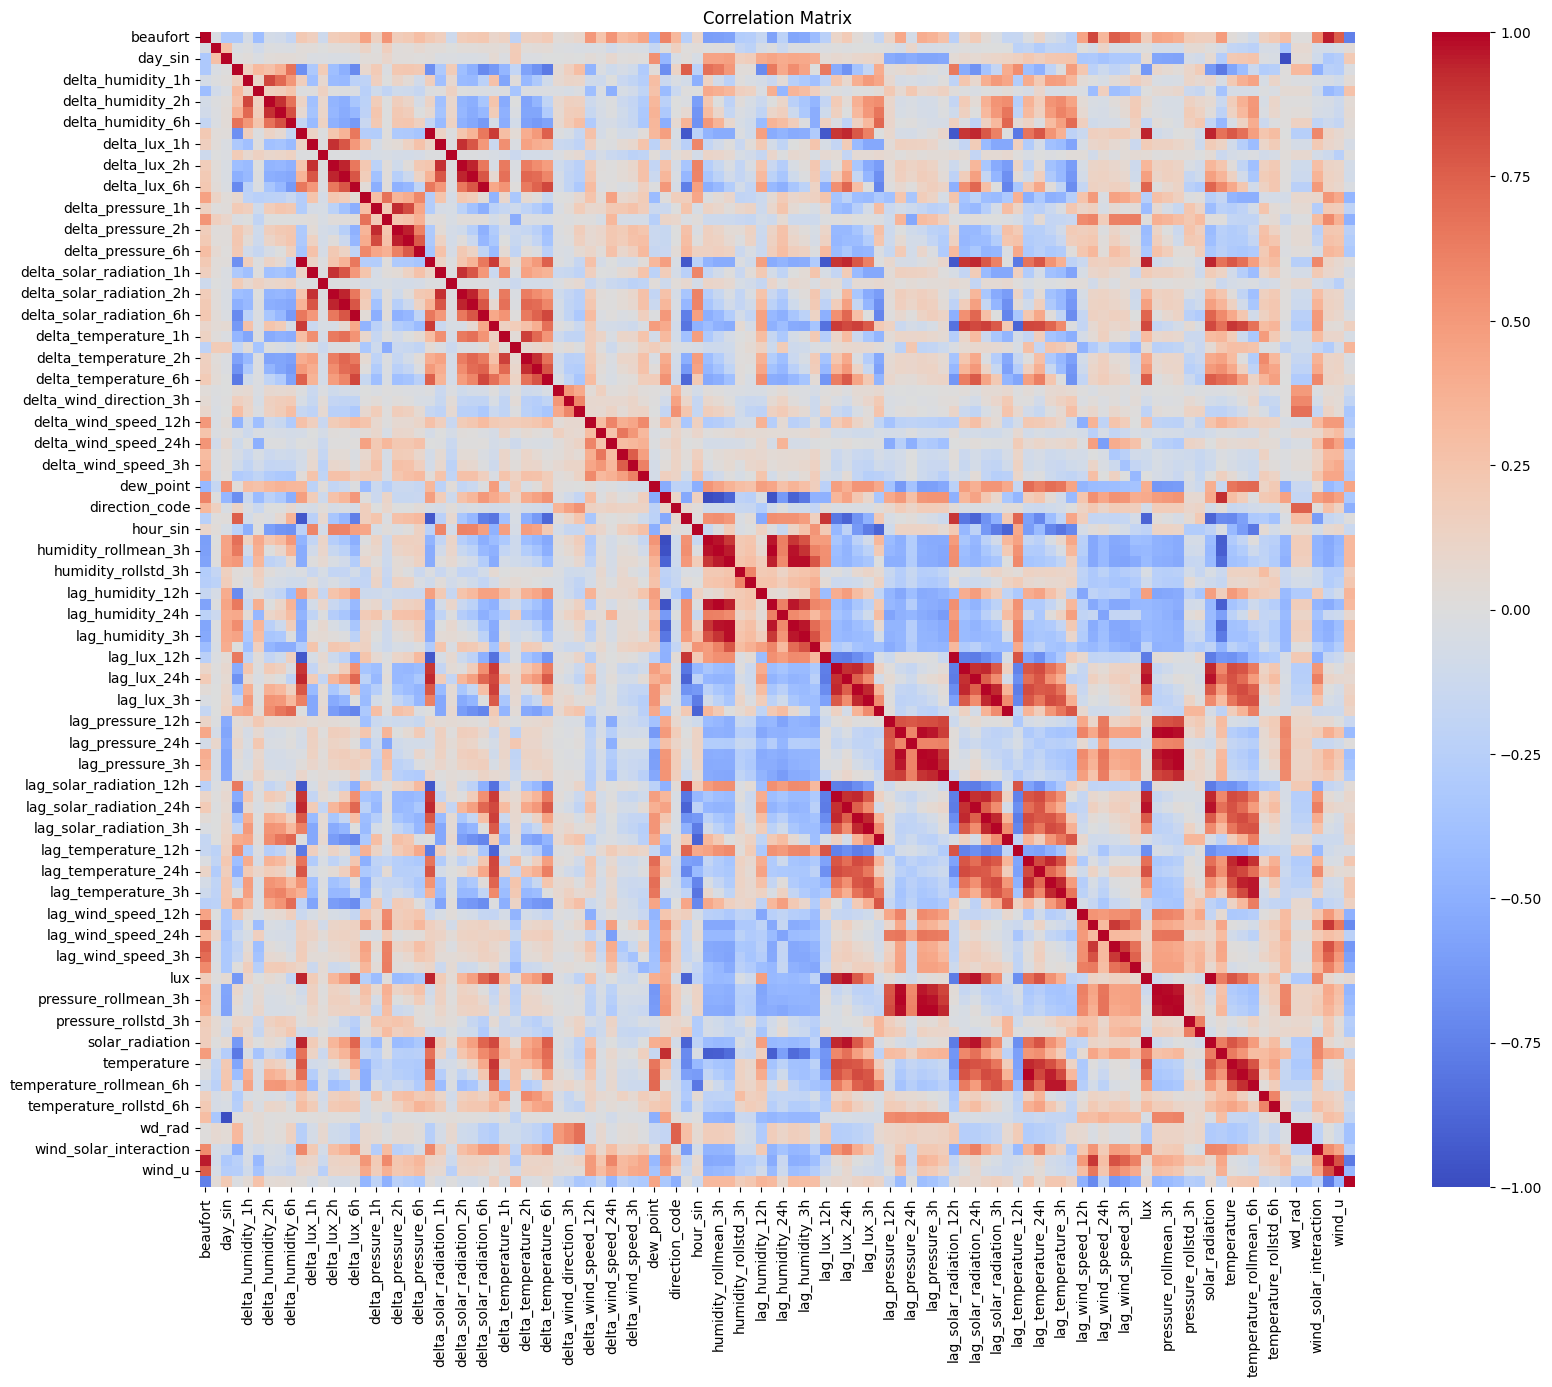

In [21]:
##Correlation analysis
out_columns = ['year', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',"month_cos","month_sin","wind_dir_cat"]
corr_matrix = data[data.columns.difference(out_columns)].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

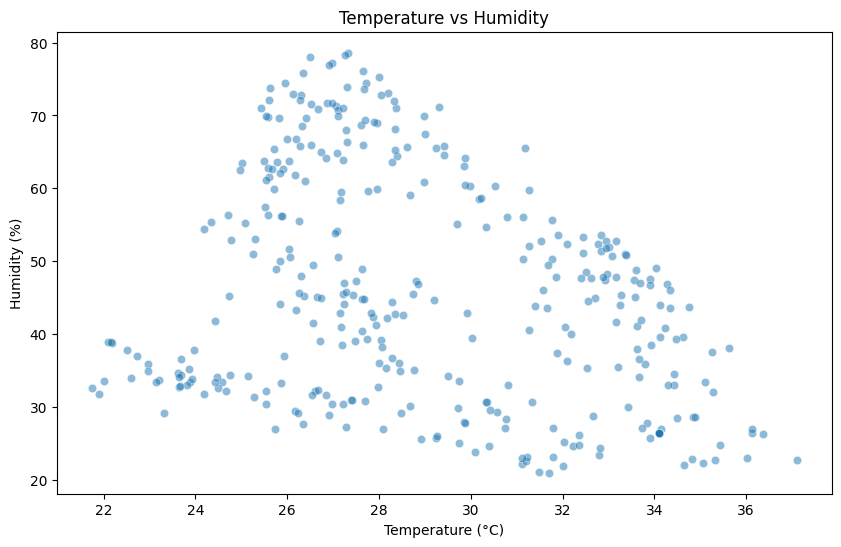

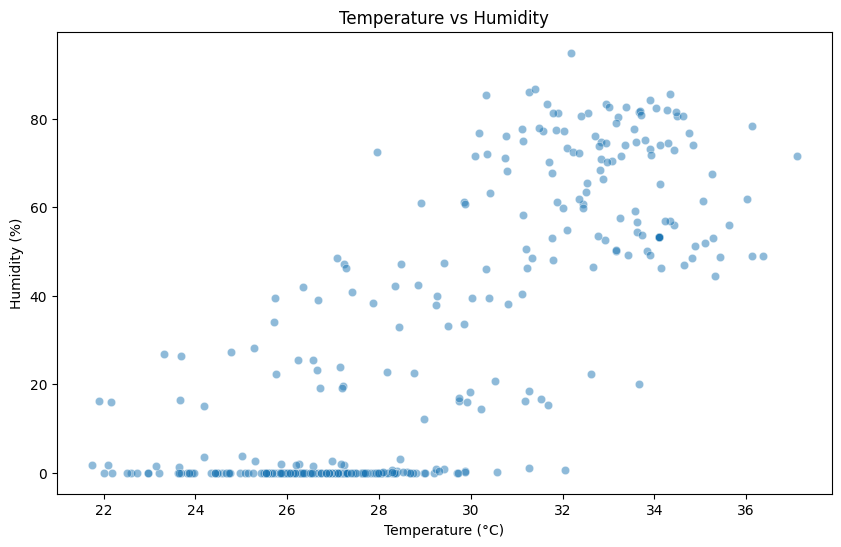

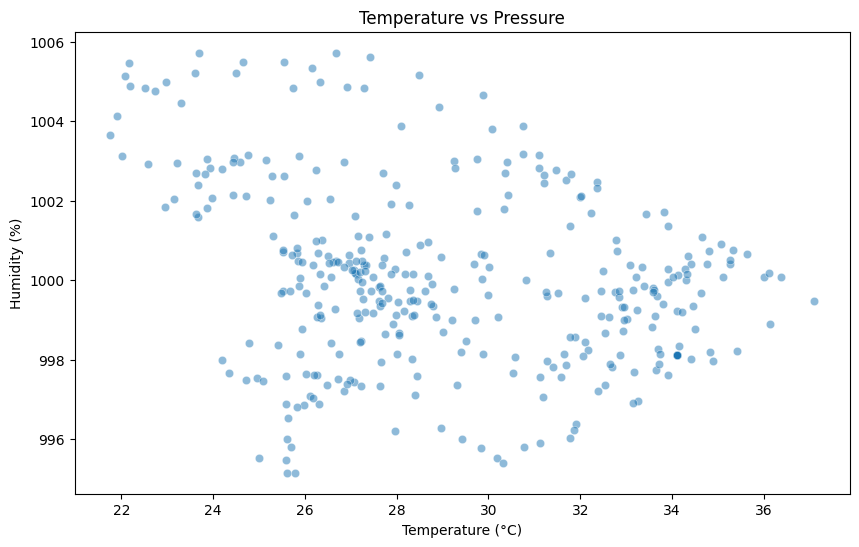

In [22]:
## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="humidity", alpha=0.5)
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Humidity Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="solar_radiation", alpha=0.5)
plt.title("Temperature vs Humidity")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

## Temperature and Pressure Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="temperature", y="pressure", alpha=0.5)
plt.title("Temperature vs Pressure")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.show()

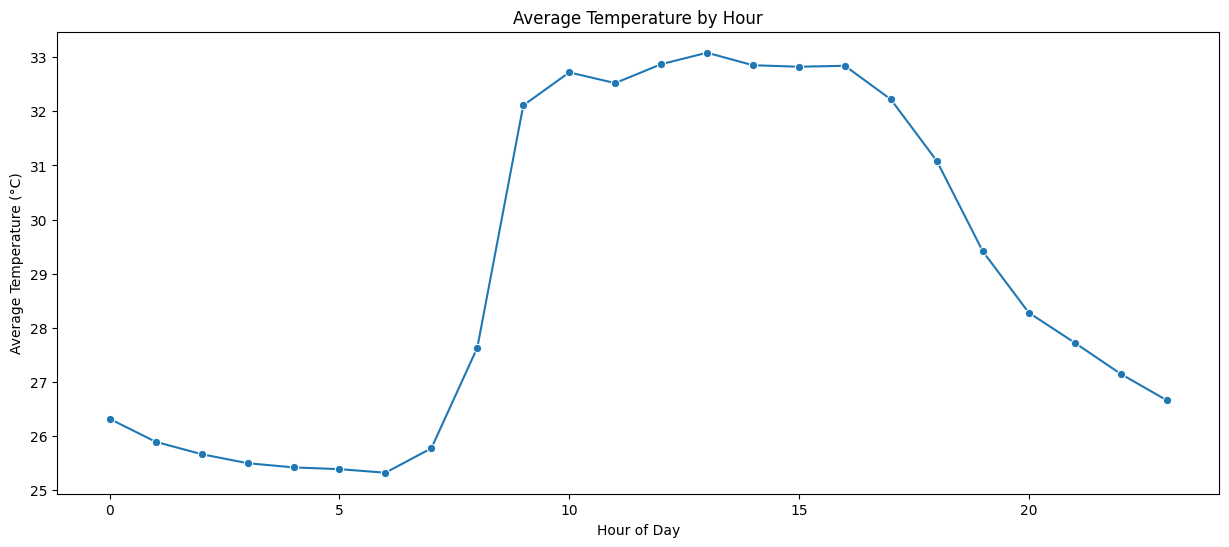

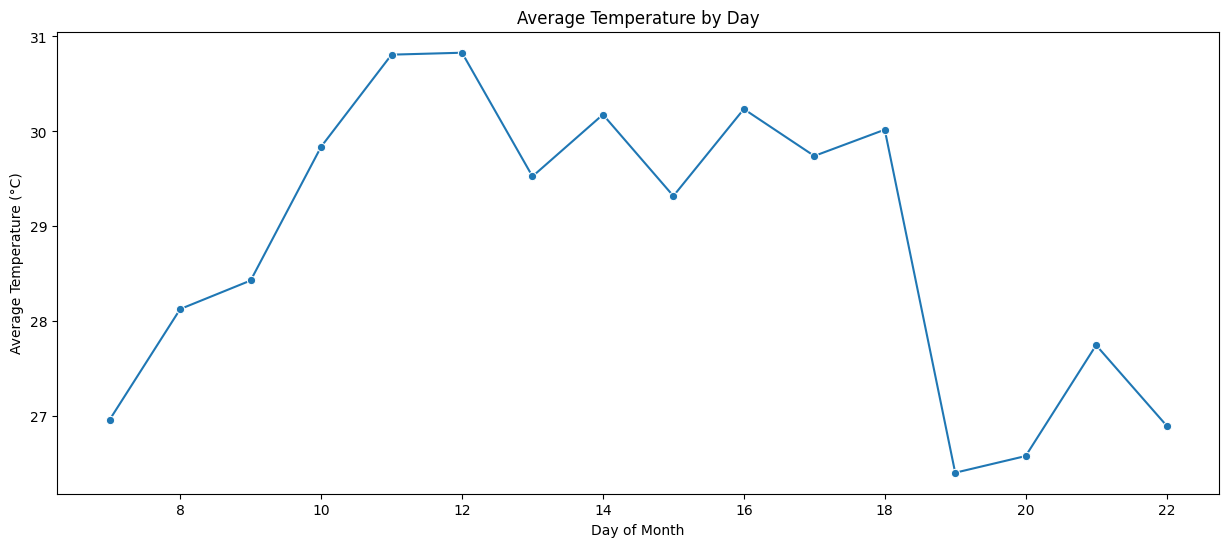

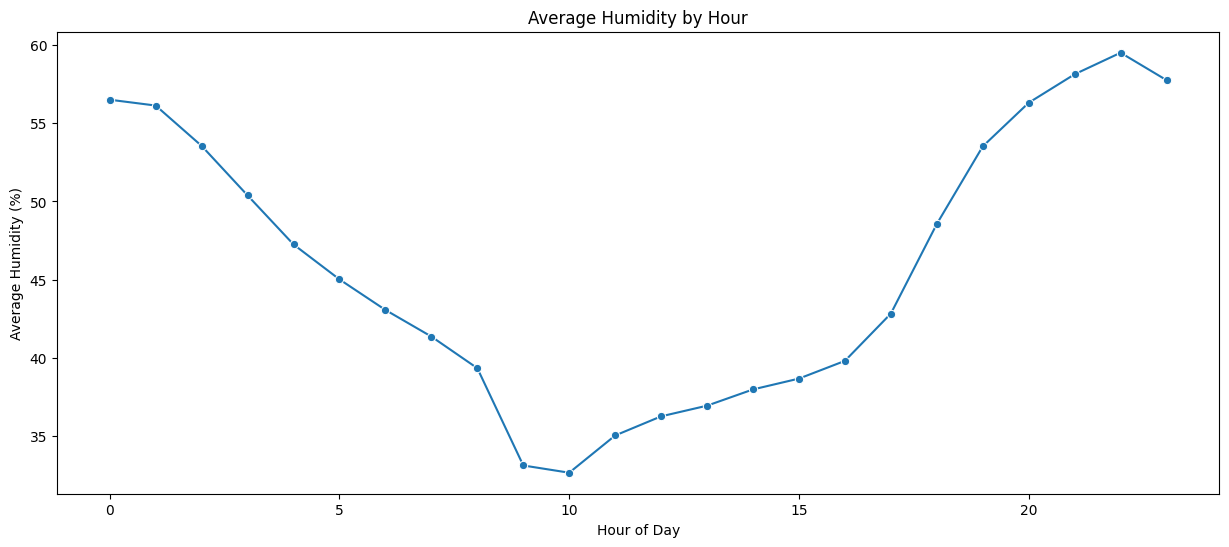

In [23]:
## Avg temperature by hour
avg_temp_by_hour = data.groupby('hour')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_hour, x='hour', y='temperature', marker='o')
plt.title("Average Temperature by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Temperature (°C)")
plt.show()

## Avg temperature by day
avg_temp_by_day = data.groupby('day')['temperature'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_temp_by_day, x='day', y='temperature', marker='o')
plt.title("Average Temperature by Day")
plt.xlabel("Day of Month")
plt.ylabel("Average Temperature (°C)")
plt.show()

##Avg humidity by hour
avg_humidity_by_hour = data.groupby('hour')['humidity'].mean().reset_index()
plt.figure(figsize=(15, 6))
sns.lineplot(data=avg_humidity_by_hour, x='hour', y='humidity', marker='o')
plt.title("Average Humidity by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Humidity (%)")
plt.show()

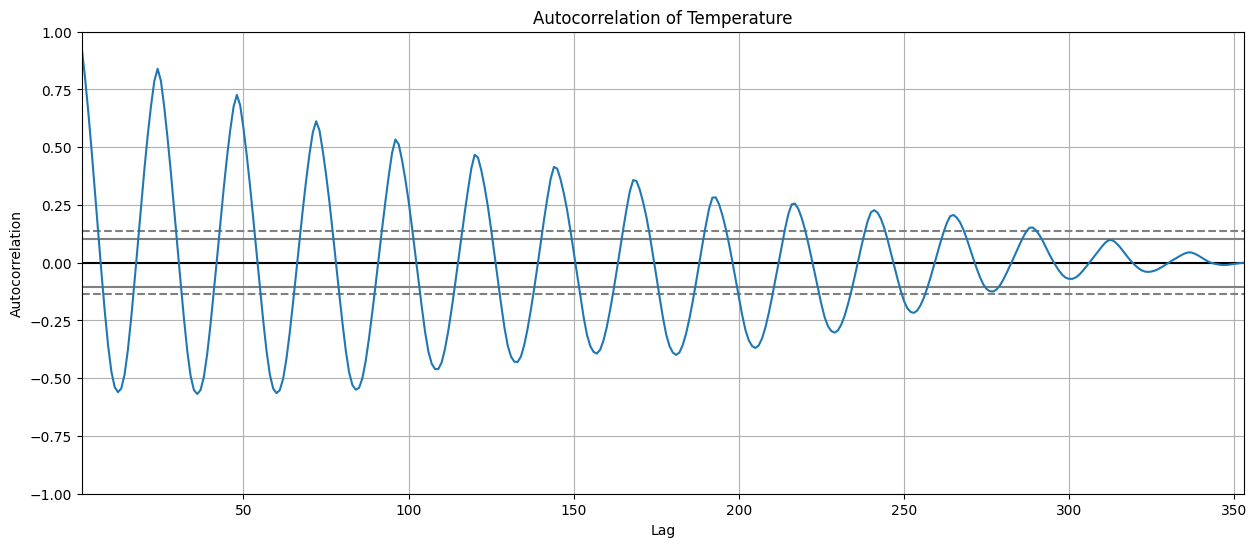

In [24]:
## Autocorrelation analysis
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15, 6))
autocorrelation_plot(data['temperature'])
plt.title("Autocorrelation of Temperature")
plt.show()

In [25]:
### ~~ MODEL ~~ ###

## Baseline Models: Persistence and Climatology
def persistence_forecast(df, horizon=12):
    """
    Persistence model: T(t+h) = T(t)
    """
    df = df.copy()
    forecasts = {}
    for h in range(1, horizon+1):
        forecasts[f"persistence_{h}h"] = df["temperature"].shift(0)  # current value
    return pd.DataFrame(forecasts)



def climatology_forecast(df, horizon=12):
    """
    Climatology model: average temperature per hour-of-day
    """
    df = df.copy()
    climatology_mean = df.groupby(df['hour'])['temperature'].mean()
    forecasts = {}
    for h in range(1, horizon+1):
        forecasts[f"climatology_{h}h"] = df['hour'].map(climatology_mean)
    return pd.DataFrame(forecasts)


from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_baseline(df_true, df_pred):
    """
    df_true: gerçek sıcaklık değerleri (DataFrame, sütun 'temperature')
    df_pred: tahminler (DataFrame, sütunlar: persistence_1h..12h, climatology_1h..12h)
    """
    horizons = range(1, 13)
    
    metrics = {"model":[], "horizon":[], "RMSE":[], "MAE":[]}
    
    for model_type in ["persistence", "climatology"]:
        for h in horizons:
            col_name = f"{model_type}_{h}h"
            y_true = df_true["temperature"].iloc[h:]  # ileri kaydır
            y_pred = df_pred[col_name].iloc[h:]
            
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            
            metrics["model"].append(model_type)
            metrics["horizon"].append(h)
            metrics["RMSE"].append(rmse)
            metrics["MAE"].append(mae)
    
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

# ==== Grafik ile karşılaştırma ====
def plot_baseline_vs_actual(df_true, df_pred, horizon=1, start=0, end=100):
    """
    start, end: plotlanacak veri aralığı
    horizon: hangi saat tahminini plotlamak istediğin
    """
    plt.figure(figsize=(15,5))
    plt.plot(df_true["temperature"].iloc[start:end], label="Gerçek")
    plt.plot(df_pred[f"persistence_{horizon}h"].iloc[start:end], label="Persistence")
    plt.plot(df_pred[f"climatology_{horizon}h"].iloc[start:end], label="Climatology")
    plt.xlabel("Zaman index")
    plt.ylabel("Sıcaklık")
    plt.title(f"{horizon} Saatlik Tahmin - Gerçek vs Baseline")
    plt.legend()
    plt.show()


          model  horizon      RMSE       MAE
0   persistence        1  0.000000  0.000000
1   persistence        2  0.000000  0.000000
2   persistence        3  0.000000  0.000000
3   persistence        4  0.000000  0.000000
4   persistence        5  0.000000  0.000000
5   persistence        6  0.000000  0.000000
6   persistence        7  0.000000  0.000000
7   persistence        8  0.000000  0.000000
8   persistence        9  0.000000  0.000000
9   persistence       10  0.000000  0.000000
10  persistence       11  0.000000  0.000000
11  persistence       12  0.000000  0.000000
12  climatology        1  1.699120  1.294117
13  climatology        2  1.701506  1.297236
14  climatology        3  1.703935  1.300925
15  climatology        4  1.706313  1.303882
16  climatology        5  1.708761  1.307464
17  climatology        6  1.711215  1.310999
18  climatology        7  1.713573  1.313729
19  climatology        8  1.716015  1.316903
20  climatology        9  1.718423  1.319817
21  climat

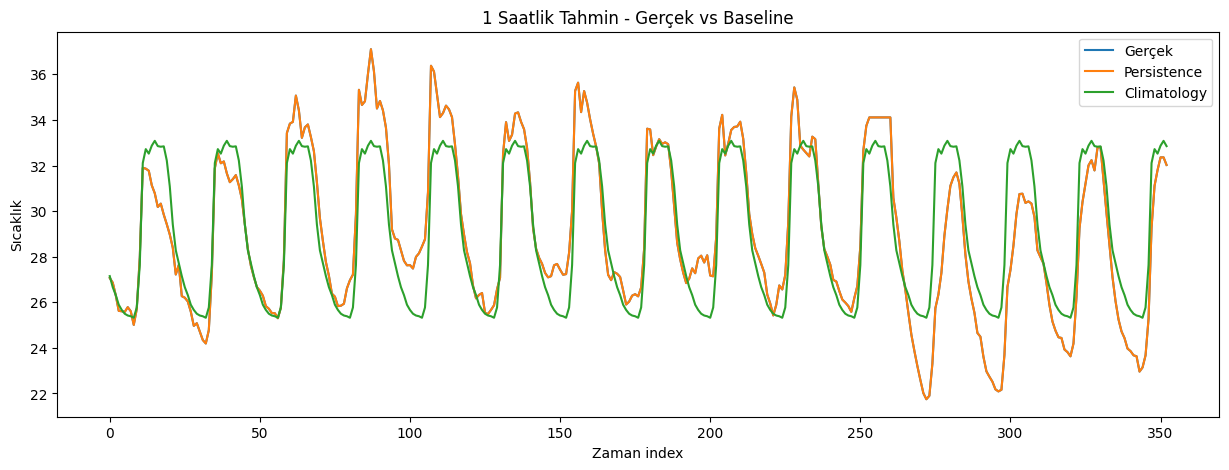

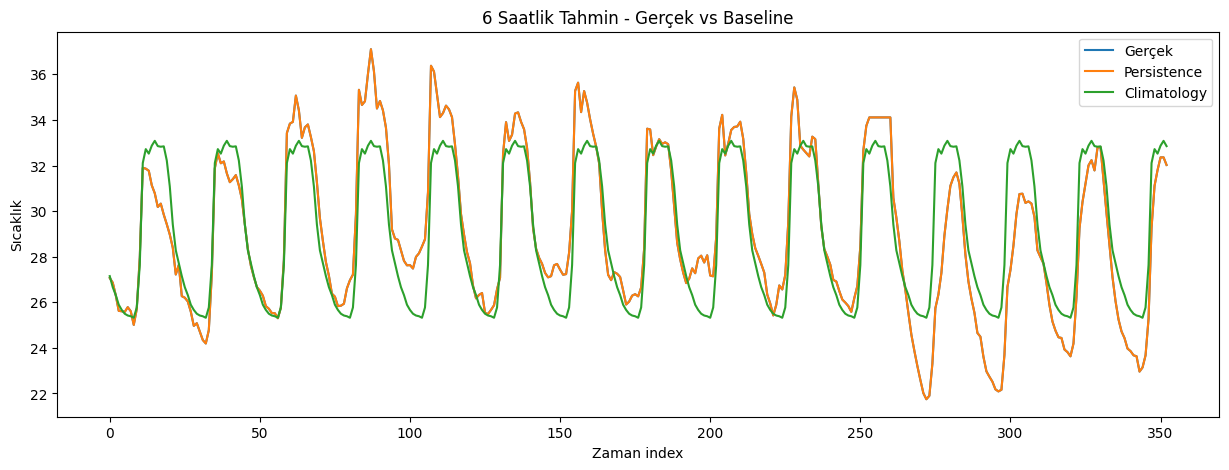

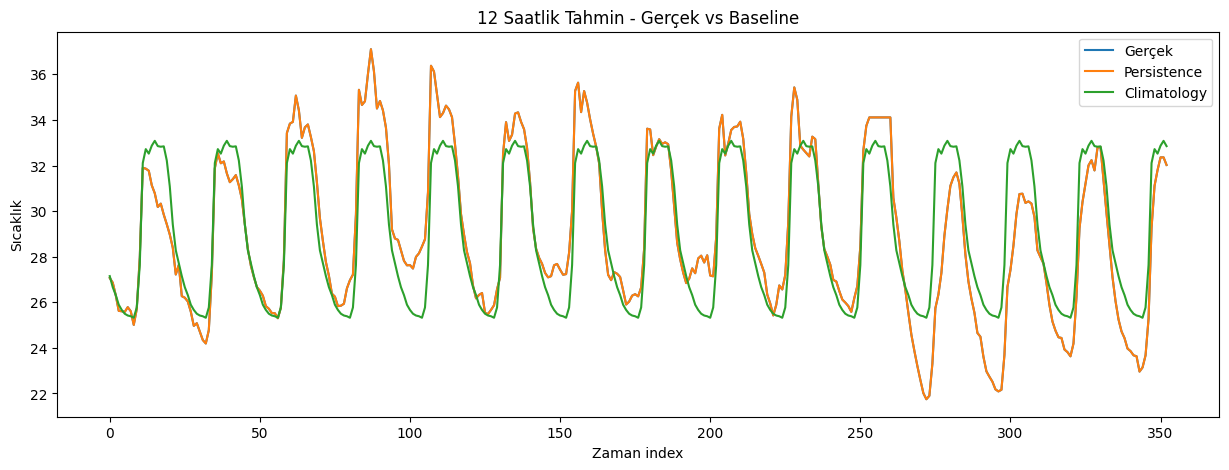

In [26]:
# ==== 1. Baseline tahminleri oluştur ====
horizon = 12  # 0–12 saat tahmin
persistence_df = persistence_forecast(data, horizon=horizon)
climatology_df = climatology_forecast(data, horizon=horizon)

# Baseline tahminlerini tek bir DataFrame'de birleştir
baseline_df = pd.concat([persistence_df, climatology_df], axis=1)

# ==== 2. Performans metriklerini hesapla ====
metrics_df = evaluate_baseline(df_true=data, df_pred=baseline_df)
print(metrics_df)

# ==== 3. Grafik ile karşılaştır ====
# Örneğin ilk 100 veri noktasını ve 1 saatlik tahmini göster
plot_baseline_vs_actual(df_true=data, df_pred=baseline_df, horizon=1, start=0, end=data.shape[0])

# İstersen diğer saatleri de görselleştirebilirsin
plot_baseline_vs_actual(df_true=data, df_pred=baseline_df, horizon=6, start=0, end=data.shape[0])
plot_baseline_vs_actual(df_true=data, df_pred=baseline_df, horizon=12, start=0, end=data.shape[0])


In [27]:
data

timestamp  temperature   humidity     pressure  \
0   2025-09-07 22:00:00+00:00    27.068000  71.356000   997.436000   
1   2025-09-07 23:00:00+00:00    26.861667  71.695833   997.221667   
2   2025-09-08 00:00:00+00:00    26.310000  72.752500   996.880000   
3   2025-09-08 01:00:00+00:00    25.623333  73.805000   996.540833   
4   2025-09-08 02:00:00+00:00    25.606667  72.156667   995.999167   
..                        ...          ...        ...          ...   
348 2025-09-22 10:00:00+00:00    31.111667  23.038333  1002.815833   
349 2025-09-22 11:00:00+00:00    31.800000  23.176667  1002.658333   
350 2025-09-22 12:00:00+00:00    32.356667  24.734167  1002.477500   
351 2025-09-22 13:00:00+00:00    32.357500  26.095000  1002.322500   
352 2025-09-22 14:00:00+00:00    32.023333  25.250000  1002.123333   

     wind_speed  wind_direction  beaufort  direction_code          lux  \
0      0.080000      278.520000  0.200000        9.000000     0.178000   
1      0.175000      255.366667  0.250000        7.333333     0.180000   
2      0.091667      277.875000  0.250000       11.000000     0.190000   
3      0.041667      314.616667  0.083333        9.916667     0.190000   
4      0.000000      314.141667  0.000000       10.000000     0.190000   
..          ...             ...       ...             ...          ...   
348    0.600000      193.758333  0.666667        8.750000  5104.511667   
349    0.191667      254.783333  0.333333        9.916667  6091.010000   
350    0.158333      174.641667  0.416667        6.500000  7832.832500   
351    0.291667      193.950000  0.416667        8.750000  9149.952500   
352    0.277778      264.844444  0.555556       11.777778  9769.983333   

     solar_radiation  ...   lag_lux_6h  lag_lux_12h   lag_lux_24h  \
0           0.000000  ...          NaN          NaN           NaN   
1           0.000000  ...          NaN          NaN           NaN   
2           0.000000  ...          NaN          NaN           NaN   
3           0.000000  ...          NaN          NaN           NaN   
4           0.000000  ...          NaN          NaN           NaN   
..               ...  ...          ...          ...           ...   
348        40.324167  ...     0.060000     0.135000   4991.615000   
349        48.119167  ...     0.077500     0.113077   5849.086667   
350        61.879167  ...   193.451667     0.083333   7577.471667   
351        72.285000  ...  2087.231667     0.065833   9171.455833   
352        77.186667  ...  3566.976667     0.060000  10295.039167   

     lag_solar_radiation_1h  lag_solar_radiation_2h  lag_solar_radiation_3h  \
0                       NaN                     NaN                     NaN   
1                  0.000000                     NaN                     NaN   
2                  0.000000                0.000000                     NaN   
3                  0.000000                0.000000                0.000000   
4                  0.000000                0.000000                0.000000   
..                      ...                     ...                     ...   
348               39.965833               28.180000               16.488333   
349               40.324167               39.965833               28.180000   
350               48.119167               40.324167               39.965833   
351               61.879167               48.119167               40.324167   
352               72.285000               61.879167               48.119167   

     lag_solar_radiation_6h  lag_solar_radiation_12h  lag_solar_radiation_24h  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       NaN                      NaN                      NaN   
4                       NaN                      NaN                      NaN   
..                      ..

Train: (317, 81) (317, 24)
Test : (12, 81) (12, 24)
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

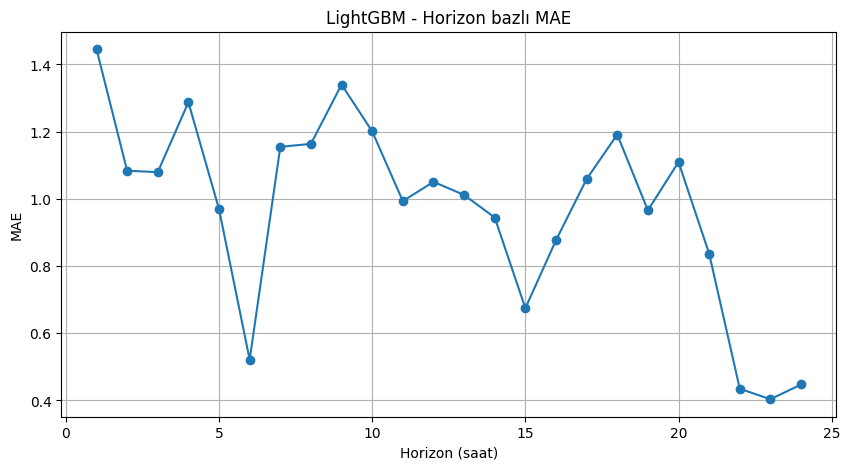

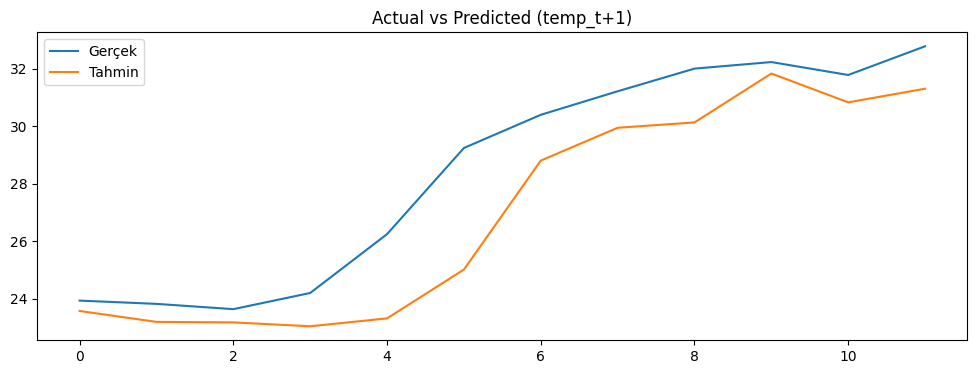

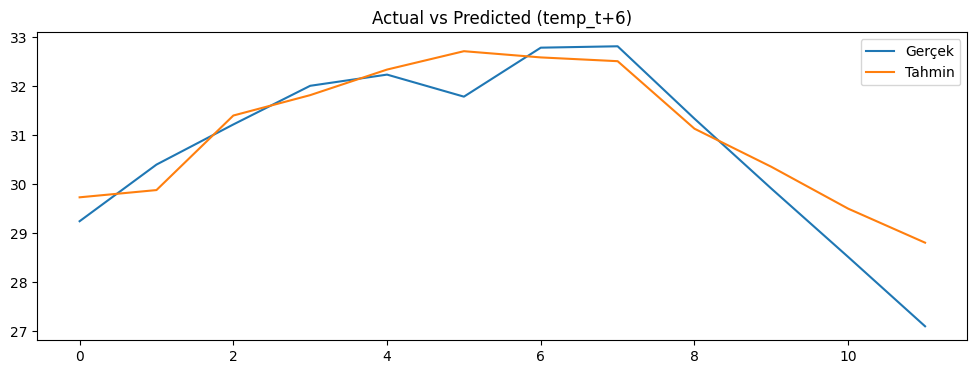

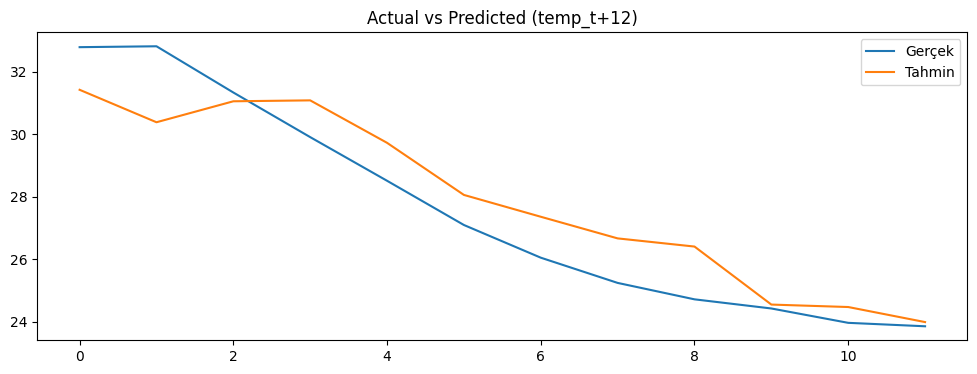

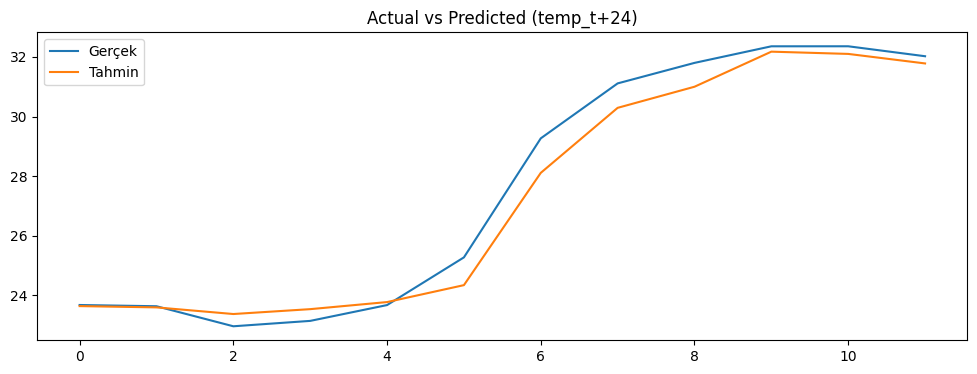

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = data.copy()

for h in range(1, 25):
    df[f"temp_t+{h}"] = df["temperature"].shift(-h)

# ---- 1) Train/Test Split ----
split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

# ---- 2) NaN temizliği ----
for dataset in [train_df, test_df]:
    # Lag & delta doldurma
    lag_delta_cols = [c for c in dataset.columns if "lag" in c or "delta" in c]
    dataset[lag_delta_cols] = dataset[lag_delta_cols].ffill().bfill()

    # Target sütunlarında NaN'ları drop et
    target_cols = [c for c in dataset.columns if "temp_t+" in c]
    dataset.dropna(subset=target_cols, inplace=True)

# ---- 3) X, Y ayır ----
feature_cols = [c for c in df.columns 
                if (("lag" in c) or ("delta" in c) or ("sin" in c) or ("cos" in c))]
target_cols  = [c for c in df.columns if "temp_t+" in c]

X_train, y_train = train_df[feature_cols], train_df[target_cols]
X_test,  y_test  = test_df[feature_cols],  test_df[target_cols]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)

# ---- 4) Direct multi-output (her horizon için ayrı model) ----
try:
    import lightgbm as lgb
    ModelClass = lgb.LGBMRegressor
    model_name = "LightGBM"
except ImportError:
    from sklearn.ensemble import GradientBoostingRegressor
    ModelClass = GradientBoostingRegressor
    model_name = "Sklearn-GBR"

models = {}
preds_test = pd.DataFrame(index=y_test.index)

for h, target in enumerate(target_cols, start=1):
    model = ModelClass()
    model.fit(X_train, y_train[target])
    preds_test[target] = model.predict(X_test)
    models[target] = model

# ---- 5) Metrikler ----
metrics = []
for target in target_cols:
    mae = mean_absolute_error(y_test[target], preds_test[target])
    rmse = mean_squared_error(y_test[target], preds_test[target], squared=False)
    mape = (np.abs((y_test[target] - preds_test[target]) / y_test[target])
            .replace([np.inf, -np.inf], np.nan).dropna().mean()) * 100
    metrics.append({"horizon": target, "MAE": mae, "RMSE": rmse, "MAPE": mape})

metrics_df = pd.DataFrame(metrics)

# ---- 6) Görselleştirme ----
plt.figure(figsize=(10,5))
plt.plot(range(1, len(metrics_df)+1), metrics_df["MAE"], marker="o")
plt.xlabel("Horizon (saat)")
plt.ylabel("MAE")
plt.title(f"{model_name} - Horizon bazlı MAE")
plt.grid(True)
plt.show()

# Örnek: 1, 6, 12, 24 saatlik horizonlar için actual vs predicted
sel_horizons = ["temp_t+1", "temp_t+6", "temp_t+12", "temp_t+24"]
for h in sel_horizons:
    plt.figure(figsize=(12,4))
    plt.plot(y_test[h].values[:200], label="Gerçek")
    plt.plot(preds_test[h].values[:200], label="Tahmin")
    plt.title(f"Actual vs Predicted ({h})")
    plt.legend()
    plt.show()

In [ ]:
## Multistep forecasting with skforecast
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Sklearn Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


models_config = {}

models_config['LightGBM'] = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    random_state=42
)

models_config['LightGBM'] = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        boosting_type='gbdt',
        num_leaves=31,
        learning_rate=0.05,
        n_estimators=100,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=-1,
        random_state=42
    )

import xgboost as xgb
models_config['XGBoost'] = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=0
)


models_config.update({
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'LinearRegression': LinearRegression()
})
    
print(f"🤖 {len(models_config)} model test edilecek: {list(models_config.keys())}")


# ---- ForecasterAutoregDirect tanımla
forecasters = {}
for model_name, model in models_config.items():
    forecaster = ForecasterAutoregDirect(
        regressor = model, 
        lags      = 24,        # geçmiş kaç saat kullanılacak
        steps     = len(X_test)         # ileriye kaç saat tahmin edilecek
    )
    forecasters[model_name] = forecaster
# ---- Fit et
for model_name, forecaster in forecasters.items():
    print(f"Model fit ediliyor: {model_name}")
    forecaster.fit(y=y_train, exog=X_train)
# ---- Tahmin et
preds_dict = {}
for model_name, forecaster in forecasters.items():
    print(f"Model tahmin ediliyor: {model_name}")
    preds = forecaster.predict(steps=len(y_test), exog=X_test)
    preds_dict[model_name] = preds




🤖 7 model test edilecek: ['LightGBM', 'XGBoost', 'RandomForest', 'GradientBoosting', 'Ridge', 'Lasso', 'LinearRegression']
Model fit ediliyor: LightGBM
Model fit ediliyor: XGBoost
Model fit ediliyor: RandomForest
Model fit ediliyor: GradientBoosting
Model fit ediliyor: Ridge
Model fit ediliyor: Lasso
Model fit ediliyor: LinearRegression
Model tahmin ediliyor: LightGBM
Model tahmin ediliyor: XGBoost
Model tahmin ediliyor: RandomForest
Model tahmin ediliyor: GradientBoosting
Model tahmin ediliyor: Ridge
Model tahmin ediliyor: Lasso
Model tahmin ediliyor: LinearRegression


AttributeError: 'Series' object has no attribute 'columns'

In [94]:
data

timestamp  temperature   humidity     pressure  \
0   2025-09-07 22:00:00+00:00    27.068000  71.356000   997.436000   
1   2025-09-07 23:00:00+00:00    26.861667  71.695833   997.221667   
2   2025-09-08 00:00:00+00:00    26.310000  72.752500   996.880000   
3   2025-09-08 01:00:00+00:00    25.623333  73.805000   996.540833   
4   2025-09-08 02:00:00+00:00    25.606667  72.156667   995.999167   
..                        ...          ...        ...          ...   
348 2025-09-22 10:00:00+00:00    31.111667  23.038333  1002.815833   
349 2025-09-22 11:00:00+00:00    31.800000  23.176667  1002.658333   
350 2025-09-22 12:00:00+00:00    32.356667  24.734167  1002.477500   
351 2025-09-22 13:00:00+00:00    32.357500  26.095000  1002.322500   
352 2025-09-22 14:00:00+00:00    32.023333  25.250000  1002.123333   

     wind_speed  wind_direction  beaufort  direction_code          lux  \
0      0.080000      278.520000  0.200000        9.000000     0.178000   
1      0.175000      255.366667  0.250000        7.333333     0.180000   
2      0.091667      277.875000  0.250000       11.000000     0.190000   
3      0.041667      314.616667  0.083333        9.916667     0.190000   
4      0.000000      314.141667  0.000000       10.000000     0.190000   
..          ...             ...       ...             ...          ...   
348    0.600000      193.758333  0.666667        8.750000  5104.511667   
349    0.191667      254.783333  0.333333        9.916667  6091.010000   
350    0.158333      174.641667  0.416667        6.500000  7832.832500   
351    0.291667      193.950000  0.416667        8.750000  9149.952500   
352    0.277778      264.844444  0.555556       11.777778  9769.983333   

     solar_radiation  ...   lag_lux_6h  lag_lux_12h   lag_lux_24h  \
0           0.000000  ...          NaN          NaN           NaN   
1           0.000000  ...          NaN          NaN           NaN   
2           0.000000  ...          NaN          NaN           NaN   
3           0.000000  ...          NaN          NaN           NaN   
4           0.000000  ...          NaN          NaN           NaN   
..               ...  ...          ...          ...           ...   
348        40.324167  ...     0.060000     0.135000   4991.615000   
349        48.119167  ...     0.077500     0.113077   5849.086667   
350        61.879167  ...   193.451667     0.083333   7577.471667   
351        72.285000  ...  2087.231667     0.065833   9171.455833   
352        77.186667  ...  3566.976667     0.060000  10295.039167   

     lag_solar_radiation_1h  lag_solar_radiation_2h  lag_solar_radiation_3h  \
0                       NaN                     NaN                     NaN   
1                  0.000000                     NaN                     NaN   
2                  0.000000                0.000000                     NaN   
3                  0.000000                0.000000                0.000000   
4                  0.000000                0.000000                0.000000   
..                      ...                     ...                     ...   
348               39.965833               28.180000               16.488333   
349               40.324167               39.965833               28.180000   
350               48.119167               40.324167               39.965833   
351               61.879167               48.119167               40.324167   
352               72.285000               61.879167               48.119167   

     lag_solar_radiation_6h  lag_solar_radiation_12h  lag_solar_radiation_24h  \
0                       NaN                      NaN                      NaN   
1                       NaN                      NaN                      NaN   
2                       NaN                      NaN                      NaN   
3                       NaN                      NaN                      NaN   
4                       NaN                      NaN                      NaN   
..                      ..

In [113]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
import warnings
warnings.filterwarnings('ignore')


df = data.copy()

# exog columns
feature_cols = [c for c in df.columns 
                if (("lag" in c) or ("delta" in c) or ("sin" in c) or ("cos" in c) or ("roll" in c) or ("hour" in c) or ("day" in c))]

# -----------------------------
# 1) Modelleri tanımla
# -----------------------------
models_config = {}

models_config['LightGBM'] = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1,
    random_state=42
)

models_config['XGBoost'] = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

models_config.update({
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    ),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'LinearRegression': LinearRegression()
})

print(f"🤖 Toplam {len(models_config)} model kullanılacak: {list(models_config.keys())}")

# -----------------------------
# 2) ForecasterAutoregDirect ile forecaster objeleri oluştur
# -----------------------------
forecasters = {}
forecast_horizon = 24  # Önümüzdeki 24 saat
lags_to_use = 24        # geçmiş 24 saat lag kullanılacak

for model_name, model in models_config.items():
    forecaster = ForecasterAutoregDirect(
        regressor = model,
        lags      = lags_to_use,
        steps     = forecast_horizon
    )
    forecasters[model_name] = forecaster

# -----------------------------
# 3) Tüm veri ile fit et
# -----------------------------
# y: target seri (temperature)
# X_exog: senin hazır feature setin (lag/delta/date feature)
# Burada tüm veri kullanılıyor → geleceğe bakış yok
for model_name, forecaster in forecasters.items():
    print(f"Model fit ediliyor: {model_name}")
    forecaster.fit(y=df['temperature'], exog=df[feature_cols])

# -----------------------------
# 4) Önümüzdeki 24 saat tahmin et
# -----------------------------
# Burada exog_features: mevcut son 24 saatlik lag/delta/date feature
lags_to_use = forecaster.lags
last_window_index = forecasters['LightGBM'].last_window.index[-1]


# exog hazırlanıyor: lag/delta feature’lar zaten hazır
X_future = df[feature_cols].tail(len(lags_to_use)).copy()

# index düzelt
X_future.index = np.arange(last_window_index + 1,
                           last_window_index + 1 + len(X_future))

preds_dict = {}
for model_name, forecaster in forecasters.items():
    print(f"Model tahmin ediliyor: {model_name}")
    preds = forecaster.predict(steps=forecast_horizon, exog=X_future)
    preds_dict[model_name] = preds

# -----------------------------
# 5) Tüm modellerin tahminlerini tek dataframe’de birleştir
# -----------------------------
all_preds_df = pd.concat(
    {model_name: preds for model_name, preds in preds_dict.items()},
    axis=1
)

print("\nÖrnek: Önümüzdeki 24 saatlik tahminler (sütunlar: model adı + step_1..step_24)")
print(all_preds_df.head())


🤖 Toplam 7 model kullanılacak: ['LightGBM', 'XGBoost', 'RandomForest', 'GradientBoosting', 'Ridge', 'Lasso', 'LinearRegression']
Model fit ediliyor: LightGBM
Model fit ediliyor: XGBoost
Model fit ediliyor: RandomForest
Model fit ediliyor: GradientBoosting
Model fit ediliyor: Ridge
Model fit ediliyor: Lasso
Model fit ediliyor: LinearRegression
Model tahmin ediliyor: LightGBM
Model tahmin ediliyor: XGBoost
Model tahmin ediliyor: RandomForest
Model tahmin ediliyor: GradientBoosting
Model tahmin ediliyor: Ridge
Model tahmin ediliyor: Lasso
Model tahmin ediliyor: LinearRegression

Örnek: Önümüzdeki 24 saatlik tahminler (sütunlar: model adı + step_1..step_24)
      LightGBM    XGBoost  RandomForest  GradientBoosting      Ridge  \
353  32.714780  32.274006     32.263982         32.537446  32.942595   
354  32.724234  32.340694     32.331914         32.757628  33.041161   
355  31.432262  31.336100     31.190849         31.334656  31.403400   
356  30.230155  29.834112     30.304062         29

In [117]:
last_datetime = df.index[-1] if isinstance(df.index, pd.DatetimeIndex) else df['timestamp'].iloc[-1]

# 1 saatlik adımlar için datetime oluştur
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1),
                                   periods=forecast_horizon,
                                   freq='H')

# Tüm modeller için forecast datetime sütunu oluştur
all_preds_with_datetime = all_preds_df.copy()
all_preds_with_datetime['forecast_datetime'] = forecast_datetimes.values

In [119]:
all_preds_with_datetime

LightGBM    XGBoost  RandomForest  GradientBoosting      Ridge  \
353  32.714780  32.274006     32.263982         32.537446  32.942595   
354  32.724234  32.340694     32.331914         32.757628  33.041161   
355  31.432262  31.336100     31.190849         31.334656  31.403400   
356  30.230155  29.834112     30.304062         29.786995  29.903364   
357  28.611819  28.496492     28.794137         28.485918  28.498129   
358  27.254671  27.253345     27.547481         27.099015  26.963260   
359  26.375330  26.227394     26.437177         26.063159  25.905553   
360  25.210174  25.272614     25.438215         25.247117  25.172765   
361  24.915462  24.797394     24.953445         24.723138  24.673243   
362  24.627589  24.556093     24.588577         24.429219  24.394357   
363  23.962933  24.109303     24.102001         23.969367  23.912738   
364  23.668598  23.945707     23.887345         23.829833  23.826155   
365  23.656917  23.679886     23.686007         23.639968  23.601938   
366  23.492793  23.629679     23.608183         23.386584  23.604154   
367  23.178274  23.066269     23.118627         22.472877  22.882408   
368  23.252048  23.166405     23.121359         22.521289  23.094723   
369  23.341509  23.988665     23.547285         23.651766  23.623022   
370  24.617811  25.376879     25.087576         25.593316  25.184240   
371  29.275396  29.173170     28.629008         29.233477  29.269908   
372  31.000380  31.226759     31.475374         31.083507  31.176626   
373  31.609509  31.760067     31.846960         31.804167  31.854158   
374  32.292028  32.468197     32.204999         32.364246  32.385264   
375  32.308050  32.314323     32.338197         32.300609  32.367905   
376  32.031005  31.957134     32.027725         32.089451  32.046512   

         Lasso  LinearRegression   forecast_datetime  
353  32.691126         32.945150 2025-09-22 15:00:00  
354  32.815021         33.042985 2025-09-22 16:00:00  
355  31.397224         31.404468 2025-09-22 17:00:00  
356  29.839338         29.882788 2025-09-22 18:00:00  
357  28.537803         28.497778 2025-09-22 19:00:00  
358  27.145988         26.959537 2025-09-22 20:00:00  
359  26.178753         25.907634 2025-09-22 21:00:00  
360  25.406996         25.166964 2025-09-22 22:00:00  
361  24.860044         24.669945 2025-09-22 23:00:00  
362  24.482484         24.394851 2025-09-23 00:00:00  
363  24.044852         23.909774 2025-09-23 01:00:00  
364  23.890039         23.826503 2025-09-23 02:00:00  
365  23.698517         23.603061 2025-09-23 03:00:00  
366  23.629382         23.604930 2025-09-23 04:00:00  
367  23.108284         22.880171 2025-09-23 05:00:00  
368  23.223584         23.095117 2025-09-23 06:00:00  
369  23.820456         23.622913 2025-09-23 07:00:00  
370  25.305322         25.181846 2025-09-23 08:00:00  
371  28.998202         29.269914 2025-09-23 09:00:00  
372  31.084469         31.178411 2025-09-23 10:00:00  
373  31.789259         31.854517 2025-09-23 11:00:00  
374  32.301140         32.389455 2025-09-23 12:00:00  
375  32.441070         32.369026 2025-09-23 13:00:00  
376  32.173990         32.045685 2025-09-23 14:00:00

In [121]:
last_datetime

Timestamp('2025-09-22 14:00:00+0000', tz='UTC')

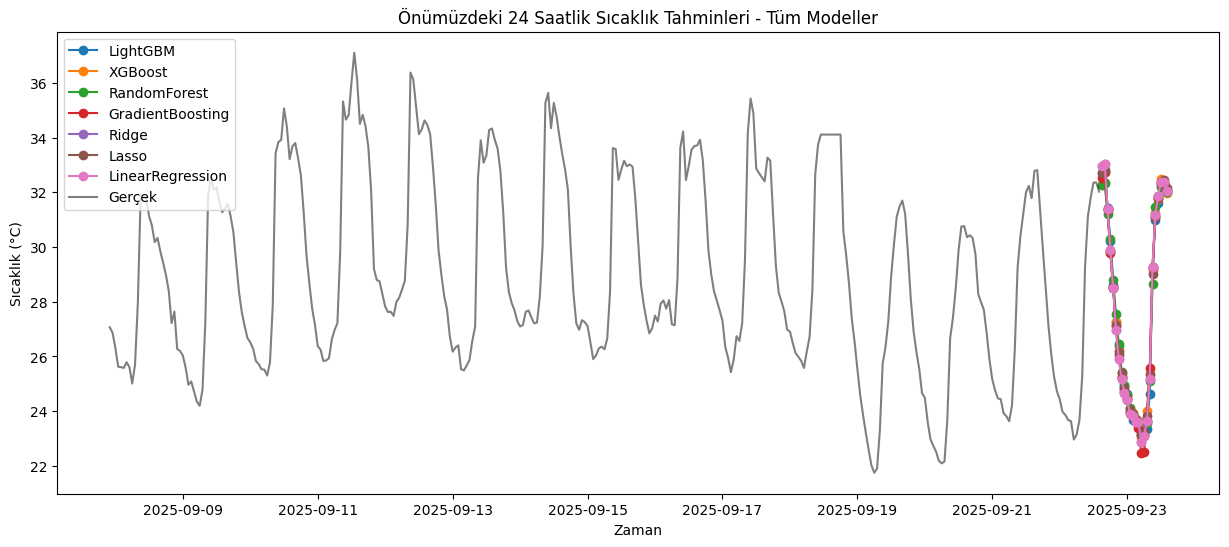

In [123]:
## Plot all model predictions
plt.figure(figsize=(15, 6))
for model_name in [x for x in all_preds_with_datetime.columns if x != 'forecast_datetime']:
    plt.plot(all_preds_with_datetime["forecast_datetime"],all_preds_with_datetime[model_name], marker='o', label=model_name)
plt.plot(df["timestamp"], df["temperature"], label="Gerçek", color='k', alpha=0.5)
plt.title("Önümüzdeki 24 Saatlik Sıcaklık Tahminleri - Tüm Modeller")
plt.xlabel("Zaman")
plt.ylabel("Sıcaklık (°C)")
plt.legend()
plt.show()

In [133]:
all_pred = all_preds_with_datetime.unstack().reset_index()
all_pred.columns = ['model', 'forecast_datetime', 'predicted_temperature']

In [135]:
all_pred["device_id"] = "1"
execute_values(conn=connection, df=all_pred, table='public.predictions')

the dataframe is inserted


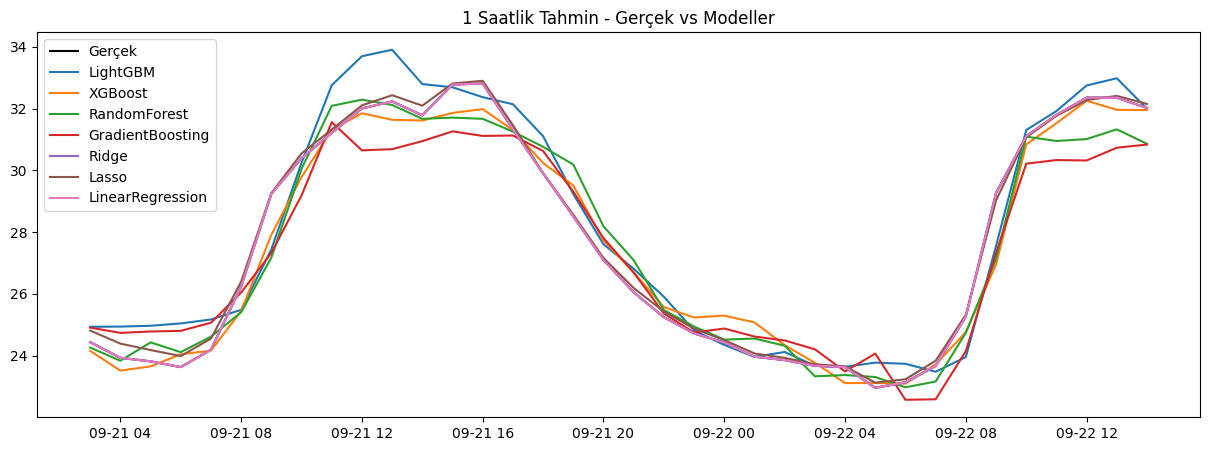

In [91]:
preds = pd.DataFrame(preds_dict, index=y_test.index)
preds["timestamp"] = data.loc[preds.index, "timestamp"].values

## plot
plt.figure(figsize=(15,5))
plt.plot(preds["timestamp"],y_test, label="Gerçek", color="black")
for model_name in models_config.keys():
    plt.plot(preds["timestamp"],preds[model_name].values, label=model_name)
plt.title("1 Saatlik Tahmin - Gerçek vs Modeller")
plt.legend()
plt.show()


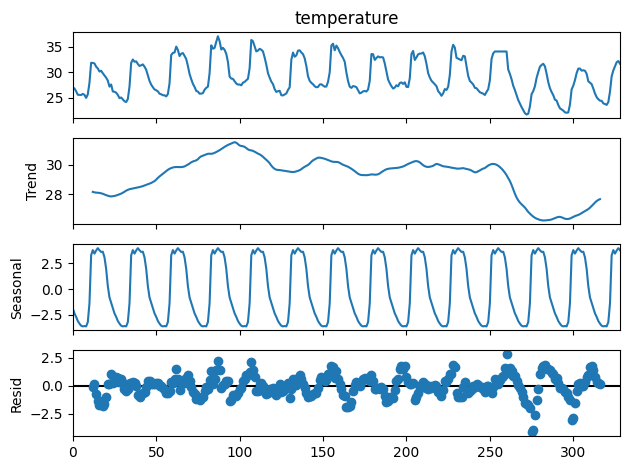

In [39]:
## time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['temperature'].dropna(), model='additive', period=24)
result.plot()
plt.show()

In [142]:
model_data = data.copy()
model_data.drop(["u","v","humidity","pressure","wind_speed","wind_direction","solar_radiation","beaufort","year_sin","year_cos"], axis=1, inplace=True)

## Create test, train and validation sets
train_size = int(len(model_data) * 0.80)
val_size = int(len(model_data) * 0.05)
train = model_data[:train_size]
val = model_data[train_size:train_size + val_size]
test = model_data[train_size + val_size:]

0:	learn: 2.2840962	test: 2.1445734	best: 2.1445734 (0)	total: 2.93ms	remaining: 583ms
100:	learn: 0.0360917	test: 0.8660199	best: 0.8268951 (20)	total: 355ms	remaining: 348ms
199:	learn: 0.0059935	test: 0.8679708	best: 0.8268951 (20)	total: 596ms	remaining: 0us

bestTest = 0.8268950917
bestIteration = 20

Shrink model to first 21 iterations.
Validation MAE: 0.67
Validation RMSE: 0.83
Test MAE: 2.09
Test RMSE: 3.00


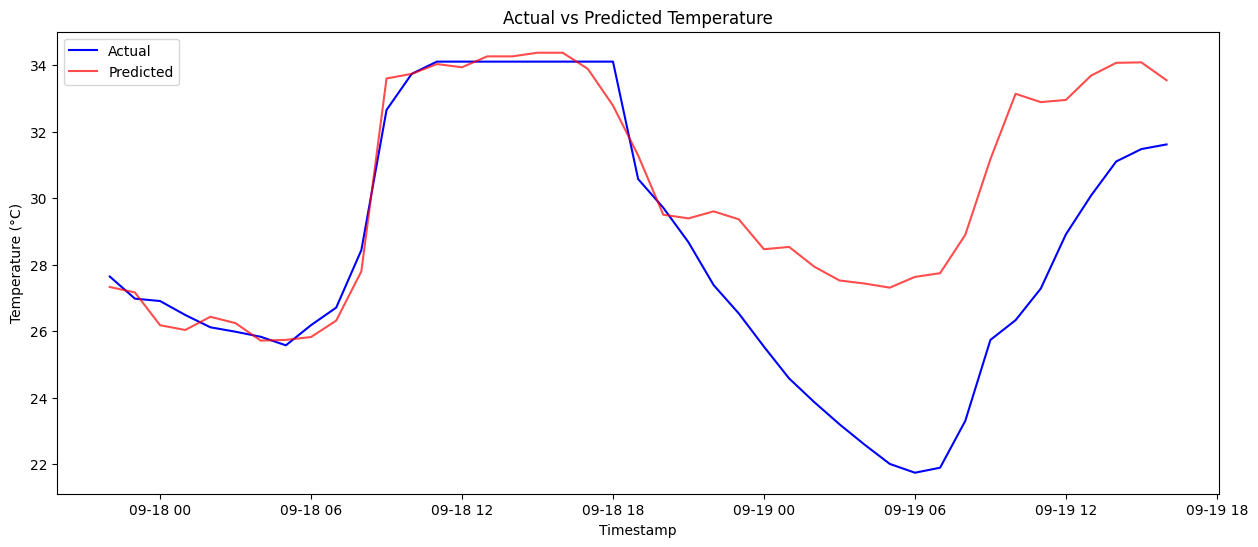

In [185]:
## Catboost regressor model and validation
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
cat_features = ['hour', 'day', 'month', 'year', 'week']
X_train = train.drop(['timestamp', 'temperature'], axis=1)
y_train = train['temperature']
X_val = val.drop(['timestamp', 'temperature'], axis=1)
y_val = val['temperature']
X_test = test.drop(['timestamp', 'temperature'], axis=1)
y_test = test['temperature']
model = CatBoostRegressor(iterations=200, learning_rate=0.4, depth=4, verbose=100)
model.fit(X_train, y_train, eval_set=(X_val, y_val))
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")
import numpy as np
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"Test MAE: {mae_test:.2f}")
import numpy as np
print(f"Test RMSE: {rmse_test:.2f}")
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()

HGB Validation MAE: 0.64
HGB Validation RMSE: 0.75
HGB Test MAE: 1.77
HGB Test RMSE: 2.80


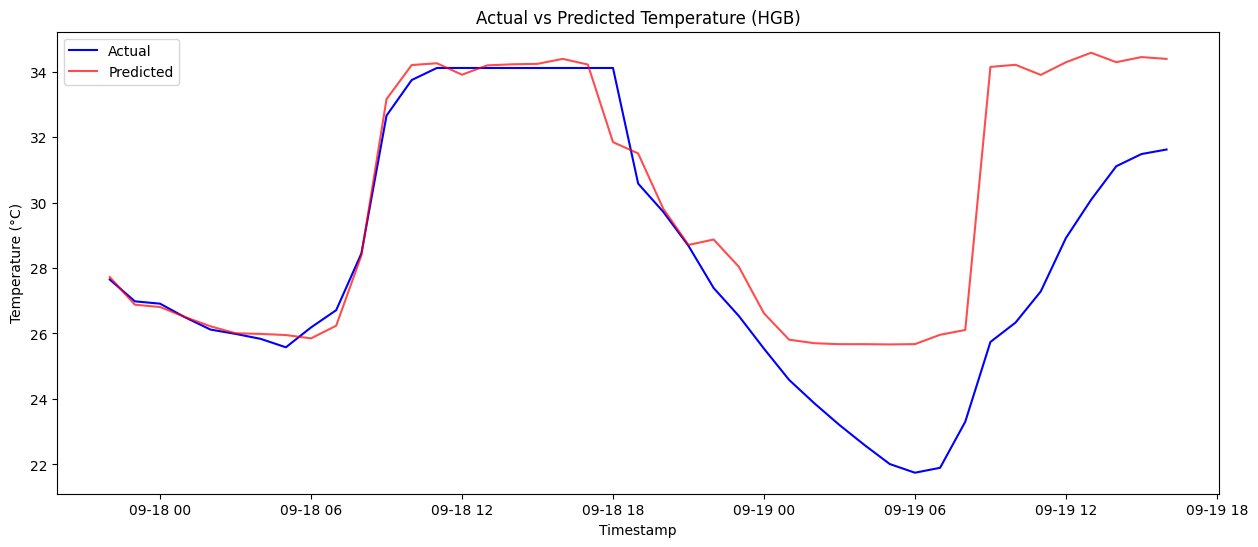

In [175]:
# Histogram gradient boosting regressor model and validation
from sklearn.ensemble import HistGradientBoostingRegressor
hgb_model = HistGradientBoostingRegressor(learning_rate=0.05,max_bins=200,max_depth=50)
hgb_model.fit(X_train, y_train)
hgb_y_pred = hgb_model.predict(X_val)
hgb_mae = mean_absolute_error(y_val, hgb_y_pred)
hgb_rmse = mean_squared_error(y_val, hgb_y_pred, squared=False)
print(f"HGB Validation MAE: {hgb_mae:.2f}")
print(f"HGB Validation RMSE: {hgb_rmse:.2f}")
y_pred_test = hgb_model.predict(X_test)
hgb_mae_test = mean_absolute_error(y_test, y_pred_test)
hgb_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"HGB Test MAE: {hgb_mae_test:.2f}")
print(f"HGB Test RMSE: {hgb_rmse_test:.2f}")

## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (HGB)')
plt.legend()
plt.show()

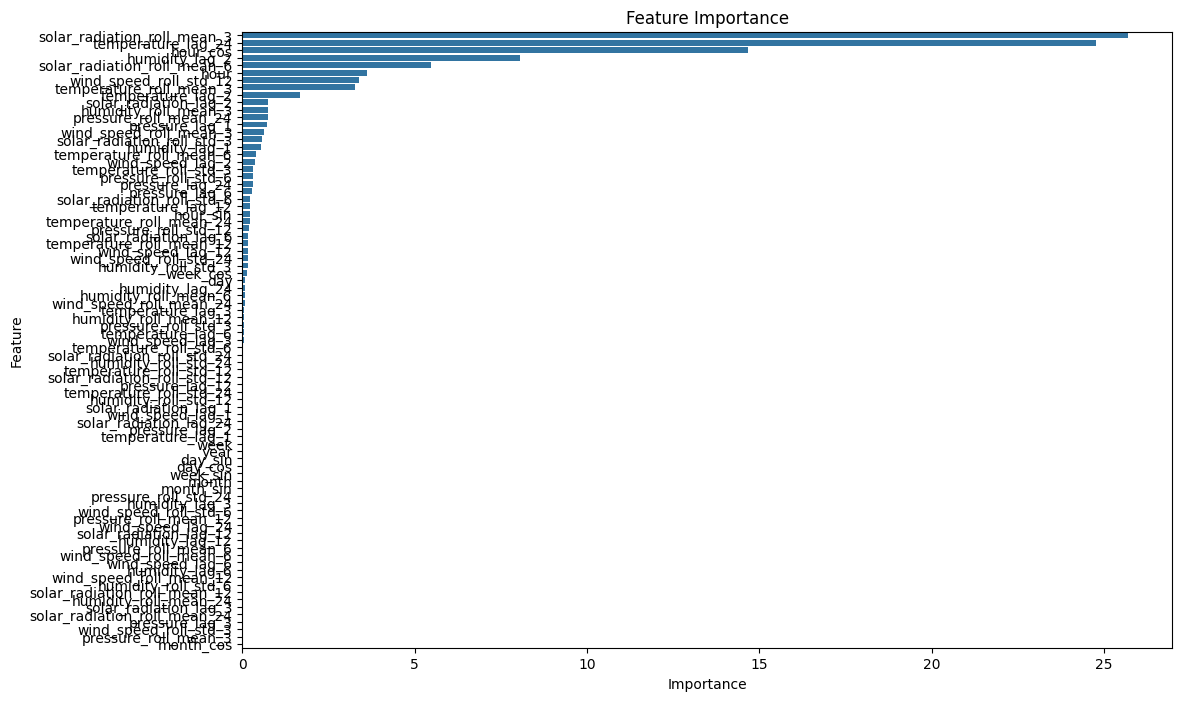

In [176]:
## Train feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

In [134]:
import psycopg2.extras as extras

def execute_values(conn, df, table):

    tuples = [tuple(x) for x in df.to_numpy()]

    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()


13:53:28 - cmdstanpy - INFO - Chain [1] start processing
13:53:30 - cmdstanpy - INFO - Chain [1] done processing


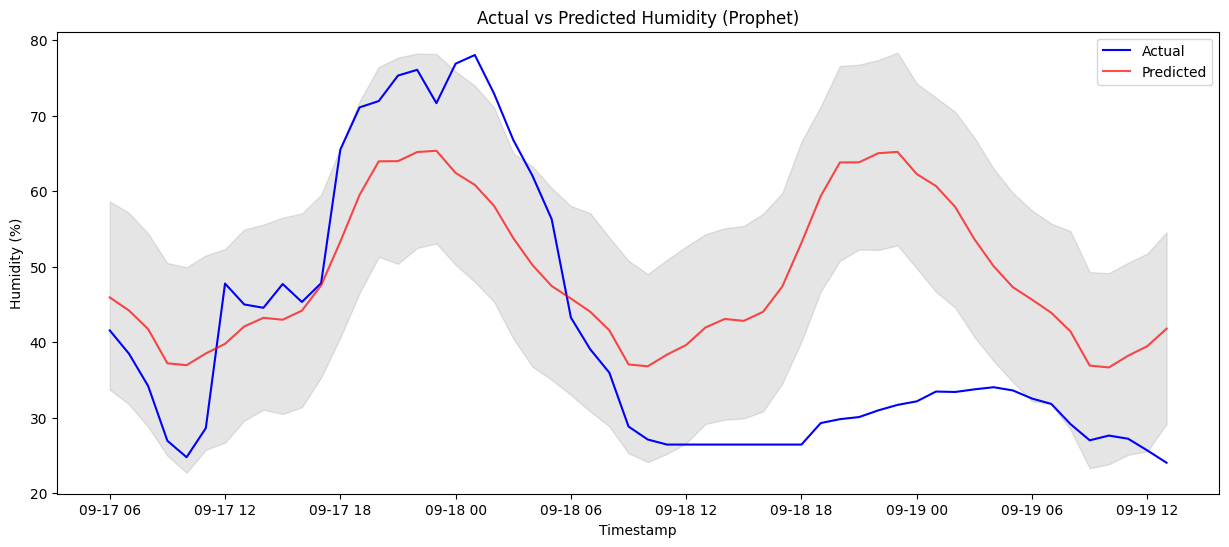

Prophet Humidity Test MAE: 13.83
Prophet Humidity Test RMSE: 16.34


In [32]:
## Prophet model and validation for humidity with date time features
from prophet import Prophet
def prophet_forecast_humidity(data, periods=24):
    # Prepare data for Prophet
    df_prophet = data[['timestamp', 'humidity']].rename(columns={'timestamp': 'ds', 'humidity': 'y'})

    #add date time features
    df_prophet['hour'] = df_prophet['ds'].dt.hour
    df_prophet['day'] = df_prophet['ds'].dt.day
    df_prophet['month'] = df_prophet['ds'].dt.month
    df_prophet['year'] = df_prophet['ds'].dt.year
    df_prophet["week"] = df_prophet['ds'].dt.isocalendar().week

    # add trigonometric features
    df_prophet["hour_sin"] = np.sin(2 * np.pi * df_prophet['hour'] / 24)
    df_prophet["hour_cos"] = np.cos(2 * np.pi * df_prophet['hour'] / 24)
    df_prophet["day_sin"] = np.sin(2 * np.pi * df_prophet['day'] / 31)
    df_prophet["day_cos"] = np.cos(2 * np.pi * df_prophet['day'] / 31)
    df_prophet["week_sin"] = np.sin(2 * np.pi * df_prophet['week'] / 52)
    df_prophet["week_cos"] = np.cos(2 * np.pi * df_prophet['week'] / 52)
    df_prophet["month_sin"] = np.sin(2 * np.pi * df_prophet['month'] / 12)
    df_prophet["month_cos"] = np.cos(2 * np.pi * df_prophet['month'] / 12)
    
    # Initialize and fit the model
    model = Prophet(
    daily_seasonality=True,
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=3.0)

    # Saatlik (günlük) döngü
    model.add_seasonality(name='half_daily', period=0.5, fourier_order=8)

    # Add regressors
    model.add_regressor('hour')
    model.add_regressor('day')
    model.add_regressor('hour_sin')
    model.add_regressor('hour_cos')


    model.fit(df_prophet)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=periods, freq='H')
    #add date time features
    future['hour'] = future['ds'].dt.hour
    future['day'] = future['ds'].dt.day

    # add trigonometric features
    future["hour_sin"] = np.sin(2 * np.pi * future['hour'] / 24)
    future["hour_cos"] = np.cos(2 * np.pi * future['hour'] / 24)

    
    # Predict
    forecast = model.predict(future)
    
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)


data["timestamp"] = data["timestamp"].dt.tz_localize(None)

## Create train and test sets for humidity
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train = data[:train_size]
test = data[train_size:]
# Forecast humidity
forecast = prophet_forecast_humidity(train, periods=test_size)

## plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], test['humidity'], label='Actual', color='b')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='r', alpha=0.7)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Actual vs Predicted Humidity (Prophet)')
plt.legend()

plt.show()

# MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test['humidity'], forecast['yhat'])
rmse = mean_squared_error(test['humidity'], forecast['yhat'], squared=False)
print(f"Prophet Humidity Test MAE: {mae:.2f}")
import numpy as np
print(f"Prophet Humidity Test RMSE: {rmse:.2f}")

In [247]:
# --- VAR ile exog tahminleri ---
from statsmodels.tsa.api import VAR
def var_forecast_exog(data, steps=24, maxlags=24):
    # Temperature hariç exog seriler
    df = data[['humidity','pressure','wind_speed','solar_radiation']].dropna()
    df = df.apply(pd.to_numeric, errors="coerce").astype(float)
    
    model = VAR(df)
    results = model.fit(maxlags=maxlags, ic='aic')
    
    forecast = results.forecast(df.values[-results.k_ar:], steps=steps)
    forecast_df = pd.DataFrame(forecast, columns=df.columns)
    
    # Zaman indexi ekle
    last_timestamp = data['timestamp'].max()
    future_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), 
                                      periods=steps, freq="H")
    forecast_df['timestamp'] = future_timestamps

    #add date time features
    forecast_df['hour'] = forecast_df['timestamp'].dt.hour
    forecast_df['day'] = forecast_df['timestamp'].dt.day
    forecast_df['month'] = forecast_df['timestamp'].dt.month
    forecast_df['year'] = forecast_df['timestamp'].dt.year
    forecast_df["week"] = forecast_df['timestamp'].dt.isocalendar().week

    # add trigonometric features
    forecast_df["hour_sin"] = np.sin(2 * np.pi * forecast_df['hour'] / 24)
    forecast_df["hour_cos"] = np.cos(2 * np.pi * forecast_df['hour'] / 24)
    forecast_df["day_sin"] = np.sin(2 * np.pi * forecast_df['day'] / 31)
    forecast_df["day_cos"] = np.cos(2 * np.pi * forecast_df['day'] / 31)
    forecast_df["week_sin"] = np.sin(2 * np.pi * forecast_df['week'] / 52)
    forecast_df["week_cos"] = np.cos(2 * np.pi * forecast_df['week'] / 52)
    forecast_df["month_sin"] = np.sin(2 * np.pi * forecast_df['month'] / 12)
    forecast_df["month_cos"] = np.cos(2 * np.pi * forecast_df['month'] / 12)
    
    return forecast_df


# --- ML rolling prediction (senin pipeline'dan uyarlama) ---
def predict_with_var_exog(model, data, shift_values, window_sizes, exog,steps=24):
    # 1) VAR ile exog tahmin et
    if exog is not None:
        exog_forecast = exog
    else:
        exog_forecast = var_forecast_exog(data, steps=steps)
    
    # 2) Extended data başlat
    extended_data = data.copy()
    predictions = []
    
    # 3) Her adım için rolling tahmin
    for i, row in exog_forecast.iterrows():
        future_time = row['timestamp']
        
        new_row = pd.DataFrame({
            'timestamp': [future_time],
            'temperature': [np.nan],  # tahmin edilecek
            'humidity': [row['humidity']],
            'pressure': [row['pressure']],
            'wind_speed': [row['wind_speed']],
            'solar_radiation': [row['solar_radiation']]
        })
        
        temp_data = pd.concat([extended_data, new_row], ignore_index=True)
        
        # Lag features
        for shift in shift_values:
            for col in ['temperature','humidity','pressure','wind_speed','solar_radiation']:
                temp_data[f'{col}_lag_{shift}'] = temp_data[col].shift(shift)
        
        # Rolling features
        for window in window_sizes:
            for col in ['temperature','humidity','pressure','wind_speed','solar_radiation']:
                temp_data[f'{col}_roll_mean_{window}'] = temp_data[col].rolling(window=window, min_periods=1).mean()
                temp_data[f'{col}_roll_std_{window}'] = temp_data[col].rolling(window=window, min_periods=1).std()
        
        last_row = temp_data.iloc[-1:].copy()
        last_row = last_row.fillna(method='ffill').fillna(method='bfill')
        
        feature_cols = [c for c in last_row.columns if c not in ['timestamp','temperature','humidity','pressure','wind_speed','solar_radiation','year_sin','year_cos','u', 'v', 'wind_direction', 'beaufort']]
        X_pred = last_row
        X_pred["hour"] = X_pred["timestamp"].dt.hour
        X_pred["day"] = X_pred["timestamp"].dt.day
        X_pred["month"] = X_pred["timestamp"].dt.month
        X_pred["year"] = X_pred["timestamp"].dt.year
        X_pred["week"] = X_pred["timestamp"].dt.isocalendar().week
        ## Trigonometric features
        X_pred["hour_sin"] = np.sin(2 * np.pi * X_pred['hour'] / 24)
        X_pred["hour_cos"] = np.cos(2 * np.pi * X_pred['hour'] / 24)
        X_pred["day_sin"] = np.sin(2 * np.pi * X_pred['day'] / 31)
        X_pred["day_cos"] = np.cos(2 * np.pi * X_pred['day'] / 31)
        X_pred["week_sin"] = np.sin(2 * np.pi * X_pred['week'] / 52)
        X_pred["week_cos"] = np.cos(2 * np.pi * X_pred['week'] / 52)
        X_pred["month_sin"] = np.sin(2 * np.pi * X_pred['month'] / 12)
        X_pred = X_pred[feature_cols]
        
        
        # ML model tahmini
        
        prediction = model.predict(X_pred)[0]
        predictions.append(prediction)
        
        # extended data’ya ekle
        new_row['temperature'] = prediction
        extended_data = pd.concat([extended_data, new_row], ignore_index=True)
    
    results_df = pd.DataFrame({
        'timestamp': exog_forecast['timestamp'],
        'predicted_temperature': predictions
    })
    return results_df,extended_data


# --- Kullanım ---
"""
shift_values = [1, 2, 3, 6, 12, 24]
window_sizes = [3, 6, 12, 24]

results_df = predict_with_var_exog(model, data, shift_values, window_sizes, steps=24)
print(results_df)
"""


'\nshift_values = [1, 2, 3, 6, 12, 24]\nwindow_sizes = [3, 6, 12, 24]\n\nresults_df = predict_with_var_exog(model, data, shift_values, window_sizes, steps=24)\nprint(results_df)\n'

0:	learn: 12.3919076	total: 524us	remaining: 209ms
100:	learn: 2.1905912	total: 29.8ms	remaining: 88.3ms
200:	learn: 1.2599798	total: 63.4ms	remaining: 62.8ms
300:	learn: 0.9054317	total: 92.7ms	remaining: 30.5ms
399:	learn: 0.7277376	total: 120ms	remaining: 0us
Validation MAE: 18.00
Validation RMSE: 23.30


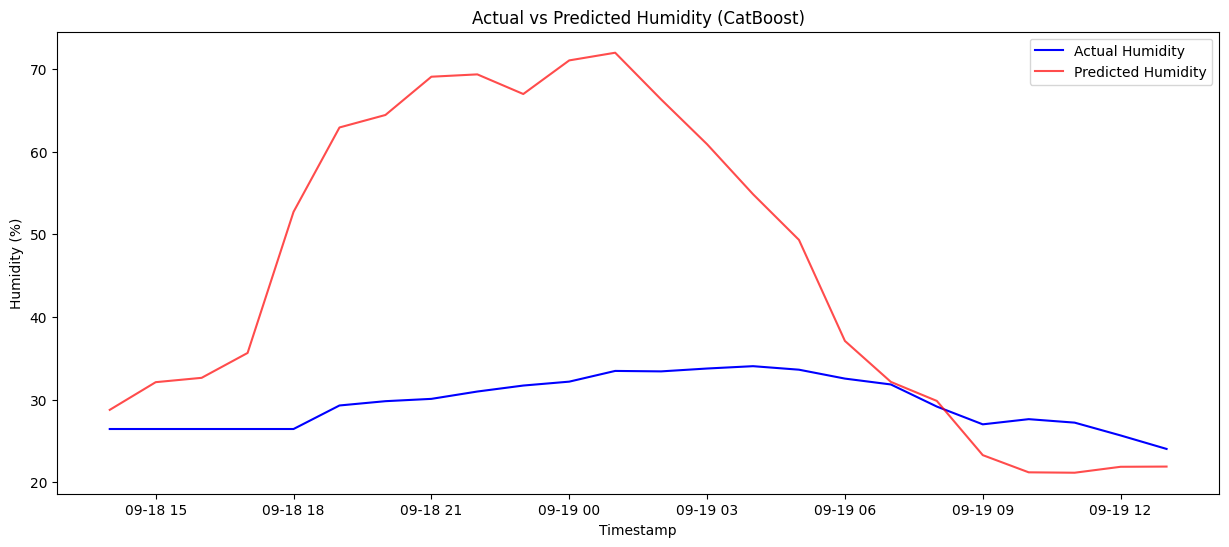

In [91]:
## Create catboost model for humidity
from catboost import CatBoostRegressor
## XGBoost model
from xgboost import XGBRegressor
cat_features = ['hour', 'day', 'month', 'year', 'week']
cat_train = data[:-24]
cat_train = cat_train[["hour","day","hour_sin","hour_cos","day_sin","day_cos"]]
y_cat = data[:-24]["humidity"]
cat_test = data[-24:]
cat_test = cat_test[["hour","day","hour_sin","hour_cos","day_sin","day_cos"]]
y_cat_test = data[-24:]["humidity"]
model = CatBoostRegressor(iterations=400, learning_rate=0.3, depth=4, verbose=100)
#model = XGBRegressor(learning_rate=0.4, n_estimators=300, max_depth=4)
model.fit(cat_train,y_cat)
y_pred = model.predict(cat_test)
mae = mean_absolute_error(y_cat_test, y_pred)
rmse = mean_squared_error(y_cat_test, y_pred, squared=False)
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")


## Plot exog forecast
plt.figure(figsize=(15, 6))
plt.plot(data[-24:]['timestamp'], y_cat_test, label='Actual Humidity', color='b')
plt.plot(data[-24:]['timestamp'], y_pred, label='Predicted Humidity', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Actual vs Predicted Humidity (CatBoost)')
plt.legend()
plt.show()




In [248]:

## Predict next 24 hour humidity with xgboost rolling prediction
main_data = pd.DataFrame()
roll_data = data[["timestamp","humidity","pressure","wind_speed","solar_radiation"]].copy()
for i in range(24):
    predict = var_forecast_exog(roll_data, steps=1,maxlags=18)
    roll_data = pd.concat([roll_data, predict[["timestamp","humidity","pressure","wind_speed","solar_radiation"]]], ignore_index=True)
    main_data = pd.concat([main_data, predict], ignore_index=True)


shift_values = [1, 2, 3, 6, 12, 24]
window_sizes = [3, 6, 12, 24]

## Fit model with all data
full_X = model_data.drop(['timestamp', 'temperature'], axis=1)
full_y = model_data['temperature']
model = CatBoostRegressor(iterations=200, learning_rate=0.4, depth=4, verbose=100, random_seed=42)
model.fit(full_X, full_y)

#hgb_model = HistGradientBoostingRegressor()
#hgb_model.fit(full_X, full_y)

results_df_hgb,ext = predict_with_var_exog(model, data, shift_values, window_sizes, steps=24,exog=None)


0:	learn: 2.5068645	total: 3.86ms	remaining: 768ms
100:	learn: 0.0782252	total: 292ms	remaining: 286ms
199:	learn: 0.0152612	total: 600ms	remaining: 0us


In [249]:
ext

timestamp  temperature   humidity     pressure  \
0   2025-09-07 22:00:00+00:00    27.068000  71.356000   997.436000   
1   2025-09-07 23:00:00+00:00    26.861667  71.695833   997.221667   
2   2025-09-08 00:00:00+00:00    26.310000  72.752500   996.880000   
3   2025-09-08 01:00:00+00:00    25.623333  73.805000   996.540833   
4   2025-09-08 02:00:00+00:00    25.606667  72.156667   995.999167   
..                        ...          ...        ...          ...   
302 2025-09-20 12:00:00+00:00    30.211362   5.387481  1003.962043   
303 2025-09-20 13:00:00+00:00    32.046512  14.691270  1003.485489   
304 2025-09-20 14:00:00+00:00    32.552123  20.567835  1002.768426   
305 2025-09-20 15:00:00+00:00    32.576175  21.376142  1002.222239   
306 2025-09-20 16:00:00+00:00    32.344325  31.847304  1001.872977   

     wind_speed  solar_radiation         u         v  wind_direction  \
0      0.080000         0.000000  0.064225 -0.047698      323.400000   
1      0.175000         0.000000  0.089978 -0.139839      302.758940   
2      0.091667         0.000000  0.066852 -0.061346      317.459654   
3      0.041667         0.000000  0.041636  0.001599        2.200000   
4      0.000000         0.000000  0.000000  0.000000        0.000000   
..          ...              ...       ...       ...             ...   
302    0.089863        67.561061       NaN       NaN             NaN   
303   -0.431220        79.415424       NaN       NaN             NaN   
304   -0.545043        85.522711       NaN       NaN             NaN   
305   -0.953106        84.839790       NaN       NaN             NaN   
306   -1.016265        75.042876       NaN       NaN             NaN   

     beaufort  ...  hour_sin  hour_cos   day_sin   day_cos  week_sin  \
0         0.0  ... -0.500000  0.866025  0.988468  0.151428 -0.935016   
1         0.0  ... -0.258819  0.965926  0.988468  0.151428 -0.935016   
2         0.0  ...  0.000000  1.000000  0.998717 -0.050649 -0.970942   
3         0.0  ...  0.258819  0.965926  0.998717 -0.050649 -0.970942   
4         0.0  ...  0.500000  0.866025  0.998717 -0.050649 -0.970942   
..        ...  ...       ...       ...       ...       ...       ...   
302       NaN  ...       NaN       NaN       NaN       NaN      <NA>   
303       NaN  ...       NaN       NaN       NaN       NaN      <NA>   
304       NaN  ...       NaN       NaN       NaN       NaN      <NA>   
305       NaN  ...       NaN       NaN       NaN       NaN      <NA>   
306       NaN  ...       NaN       NaN       NaN       NaN      <NA>   

     week_cos  month_sin     month_cos  year_sin  year_cos  
0   -0.354605       -1.0 -1.836970e-16       NaN       NaN  
1   -0.354605       -1.0 -1.836970e-16       NaN       NaN  
2   -0.239316       -1.0 -1.836970e-16       NaN       NaN  
3   -0.239316       -1.0 -1.836970e-16       NaN       NaN  
4   -0.239316       -1.0 -1.836970e-16       NaN       NaN  
..        ...        ...           ...       ...       ...  
302      <NA>        NaN           NaN       NaN       NaN  
303      <NA>        NaN           NaN       NaN       NaN  
304      <NA>        NaN           NaN       NaN       NaN  
305      <NA>        NaN           NaN       NaN       NaN  
306      <NA>        NaN           NaN       NaN       NaN  

[307 rows x 95 columns]

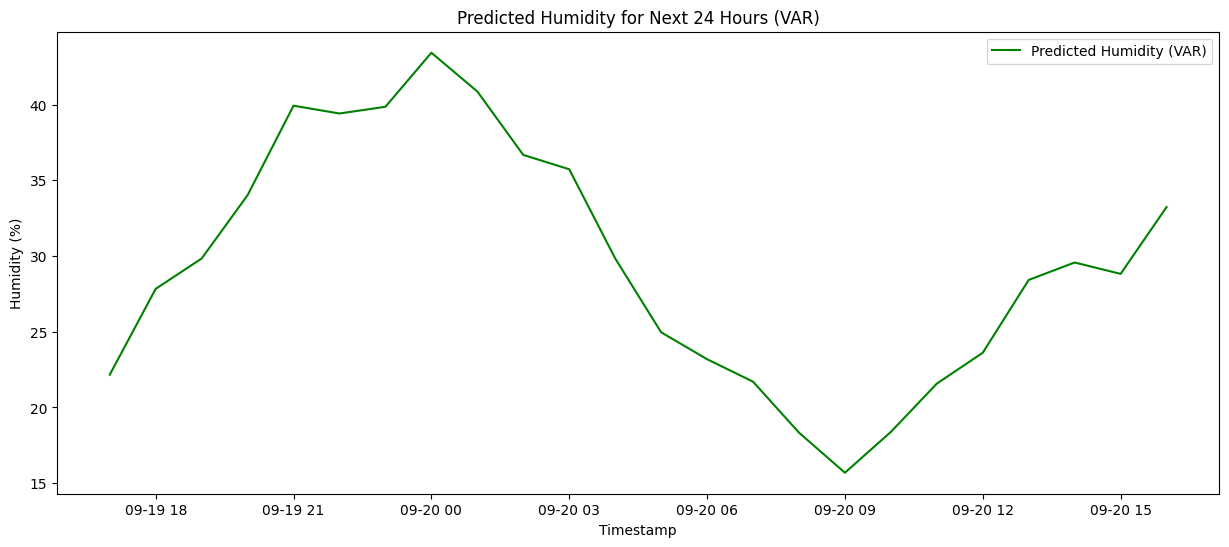

In [242]:
plt.figure(figsize=(15, 6))
plt.plot(pred['timestamp'], pred['humidity'], label='Predicted Humidity (VAR)', color='g')
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Predicted Humidity for Next 24 Hours (VAR)')
plt.legend()
plt.show()

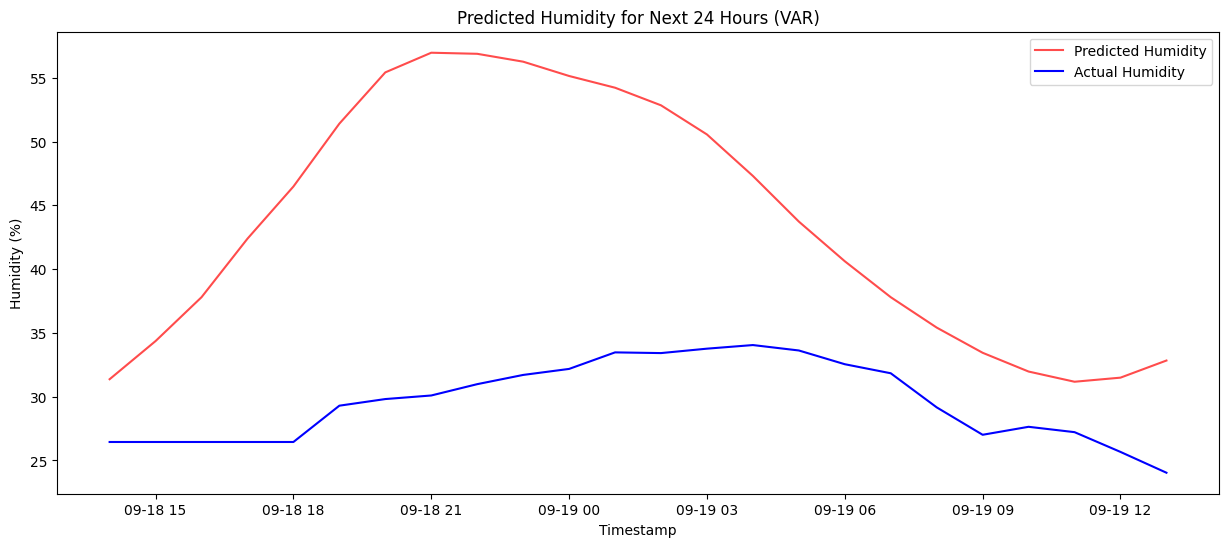

VAR Humidity Test MAE: 14.09
VAR Humidity Test RMSE: 16.11


In [120]:
var_f = var_forecast_exog(data[:-24][["timestamp","humidity","pressure","wind_speed","solar_radiation"]], steps=24, maxlags=12)

#plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(var_f['timestamp'], var_f['humidity'], label='Predicted Humidity', color='r', alpha=0.7)
plt.plot(data[-24:]['timestamp'], data[-24:]['humidity'], label='Actual Humidity', color='b')
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Predicted Humidity for Next 24 Hours (VAR)')
plt.legend()
plt.show()

## Mae and rmse
mae = mean_absolute_error(data[-24:]['humidity'], var_f['humidity'])
rmse = mean_squared_error(data[-24:]['humidity'], var_f['humidity'], squared=False)
print(f"VAR Humidity Test MAE: {mae:.2f}")
print(f"VAR Humidity Test RMSE: {rmse:.2f}")

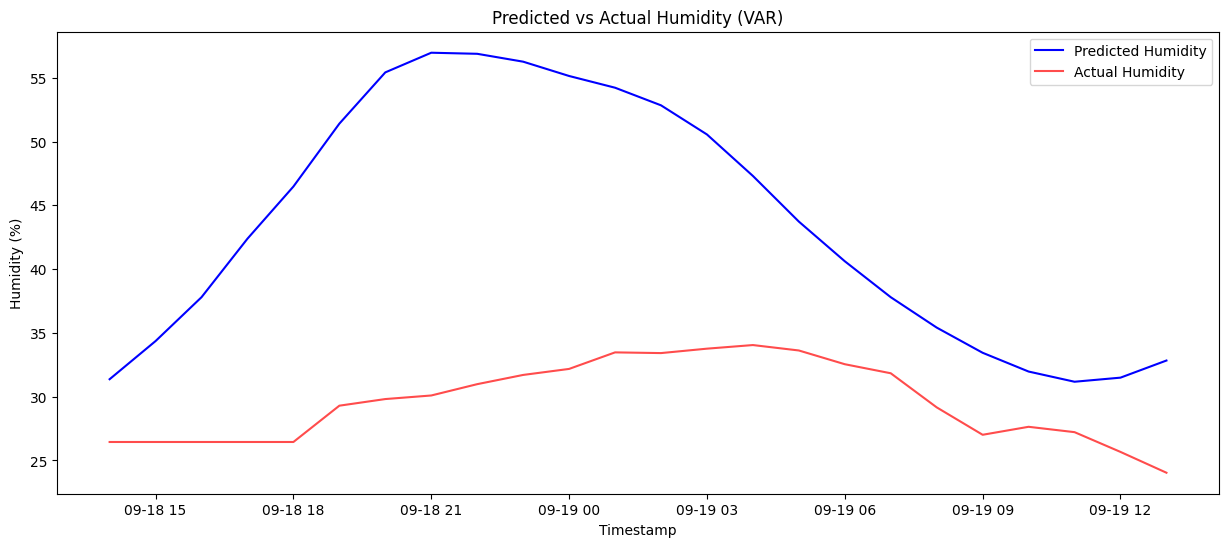

14.0850309443002


In [70]:
var_train = data[:-24]
var_test = data[-24:]
exog = var_forecast_exog(var_train, steps=24, maxlags=12)

## Plot exog forecast
plt.figure(figsize=(15, 6))
plt.plot(exog['timestamp'], exog['humidity'], label='Predicted Humidity', color='b')
plt.plot(var_test['timestamp'], var_test['humidity'], label='Actual Humidity', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Predicted vs Actual Humidity (VAR)')
plt.legend()
plt.show()

print(mean_absolute_error(var_test['humidity'], exog['humidity']))

C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


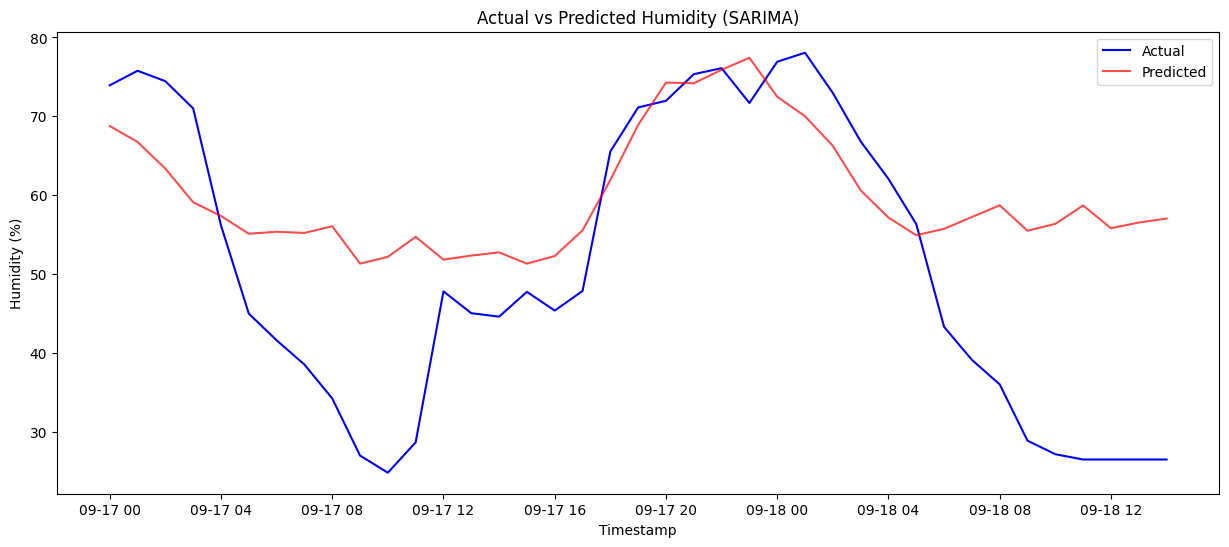

SARIMA Test MAE: 12.68


In [50]:
## Create train and test set for last 48 hours with seasonal ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
train_size = int(len(data) * 0.85)
train, test = data[:train_size], data[train_size:]
model = SARIMAX(train['humidity'], order=(3,1,3), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

## Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], test['humidity'], label='Actual', color='b')
plt.plot(test['timestamp'], y_pred, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Humidity (%)')
plt.title('Actual vs Predicted Humidity (SARIMA)')
plt.legend()
plt.show()

print(f"SARIMA Test MAE: {mean_absolute_error(test['humidity'], y_pred):.2f}")

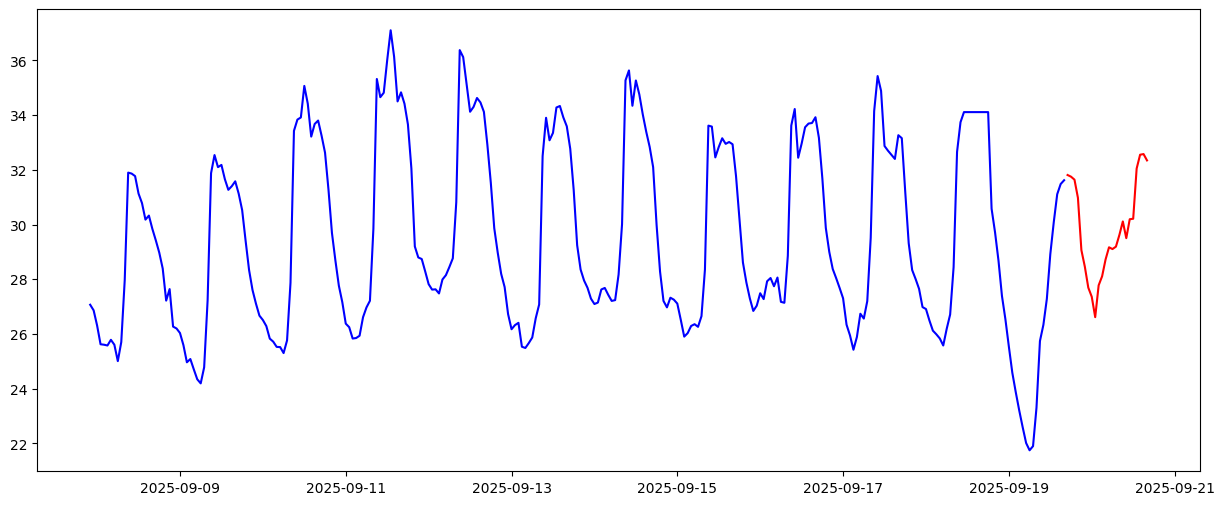

In [250]:
plt.figure(figsize=(15, 6))
plt.plot(results_df_hgb['timestamp'], results_df_hgb['predicted_temperature'], label='Humidity', color='r')
plt.plot(data['timestamp'], data['temperature'], label='Humidity', color='b')

plt.show()

In [33]:
shift_values = [1, 2, 3, 6, 12, 24]
window_sizes = [3, 6, 12, 24]

## Fit model with all data
full_X = model_data.drop(['timestamp', 'temperature'], axis=1)
full_y = model_data['temperature']
model.fit(full_X, full_y)

results_df = predict_with_var_exog(model, data, shift_values, window_sizes, steps=48)

0:	learn: 2.5557383	total: 3.3ms	remaining: 1.32s
100:	learn: 0.0694270	total: 267ms	remaining: 789ms
200:	learn: 0.0144408	total: 447ms	remaining: 443ms
300:	learn: 0.0032160	total: 677ms	remaining: 223ms
399:	learn: 0.0008070	total: 874ms	remaining: 0us
     hour  day  month  year  week  temperature_lag_1  humidity_lag_1  \
236   NaN  NaN    NaN   NaN  <NA>            33.4825           43.71   

     pressure_lag_1  wind_speed_lag_1  solar_radiation_lag_1  ...  \
236        996.8525             0.025                59.7575  ...   

     wind_speed_roll_std_24  solar_radiation_roll_std_24  hour_sin  hour_cos  \
236                0.319569                    31.654654       NaN       NaN   

     day_sin  day_cos  week_sin  week_cos  month_sin  month_cos  
236      NaN      NaN      <NA>      <NA>        NaN        NaN  

[1 rows x 83 columns]
     hour  day  month  year  week  temperature_lag_1  humidity_lag_1  \
237   NaN  NaN    NaN   NaN  <NA>          31.205906       50.981265   


In [31]:
shift_values = [1, 2, 3, 6, 12, 24]
window_sizes = [3, 6, 12, 24]

## Fit model with all data
full_X = model_data.drop(['timestamp', 'temperature'], axis=1)
full_y = model_data['temperature']
hgb_model.fit(full_X, full_y)

results_df_hgb = predict_with_var_exog(hgb_model, data, shift_values, window_sizes, steps=48)
print(results_df_hgb)

     hour  day  month  year  week  temperature_lag_1  humidity_lag_1  \
236   NaN  NaN    NaN   NaN  <NA>            33.4825           43.71   

     pressure_lag_1  wind_speed_lag_1  solar_radiation_lag_1  ...  \
236        996.8525             0.025                59.7575  ...   

     wind_speed_roll_std_24  solar_radiation_roll_std_24  hour_sin  hour_cos  \
236                0.319569                    31.654654       NaN       NaN   

     day_sin  day_cos  week_sin  week_cos  month_sin  month_cos  
236      NaN      NaN      <NA>      <NA>        NaN        NaN  

[1 rows x 83 columns]
     hour  day  month  year  week  temperature_lag_1  humidity_lag_1  \
237   NaN  NaN    NaN   NaN  <NA>          32.366472       50.981265   

     pressure_lag_1  wind_speed_lag_1  solar_radiation_lag_1  ...  \
237      996.922654         -0.249879              34.501167  ...   

     wind_speed_roll_std_24  solar_radiation_roll_std_24  hour_sin  hour_cos  \
237                0.317937         

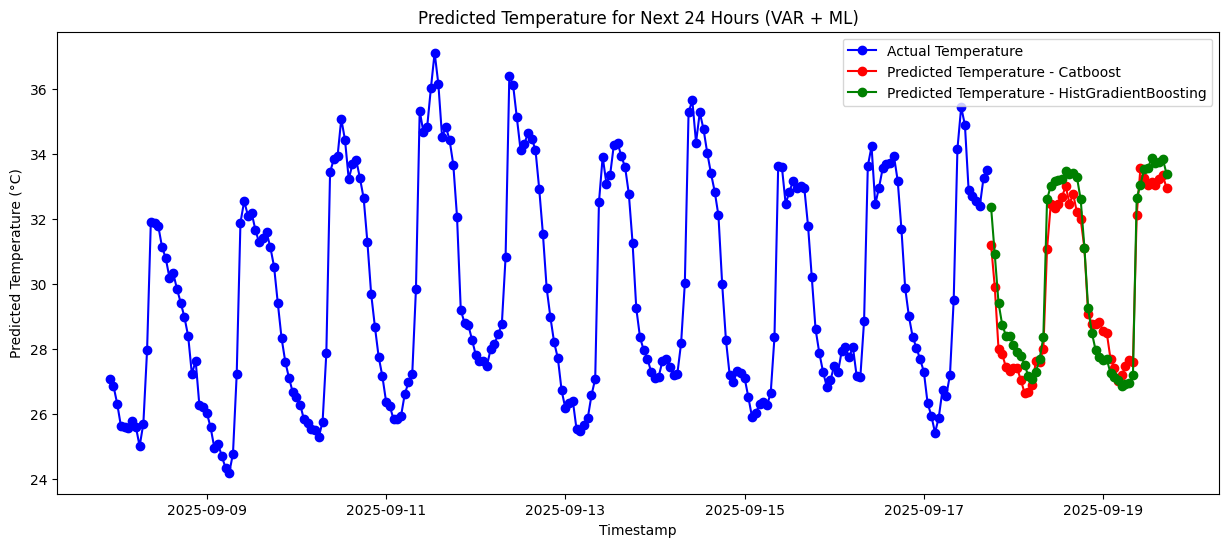

In [34]:
plt.figure(figsize=(15, 6))
plt.plot(data['timestamp'], data['temperature'], marker='o', label='Actual Temperature', color='b')
plt.plot(results_df['timestamp'], results_df['predicted_temperature'], marker='o', label='Predicted Temperature - Catboost', color='r')
plt.plot(results_df_hgb['timestamp'], results_df_hgb['predicted_temperature'], marker='o', label='Predicted Temperature - HistGradientBoosting', color='g')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Temperature for Next 24 Hours (VAR + ML)')
plt.legend()

In [37]:
results_df_hgb

timestamp  predicted_temperature
0  2025-09-17 18:00:00+00:00              32.366472
1  2025-09-17 19:00:00+00:00              30.900488
2  2025-09-17 20:00:00+00:00              29.416405
3  2025-09-17 21:00:00+00:00              28.730173
4  2025-09-17 22:00:00+00:00              28.408582
5  2025-09-17 23:00:00+00:00              28.391157
6  2025-09-18 00:00:00+00:00              28.119573
7  2025-09-18 01:00:00+00:00              27.906749
8  2025-09-18 02:00:00+00:00              27.770999
9  2025-09-18 03:00:00+00:00              27.514013
10 2025-09-18 04:00:00+00:00              27.154463
11 2025-09-18 05:00:00+00:00              27.087183
12 2025-09-18 06:00:00+00:00              27.284759
13 2025-09-18 07:00:00+00:00              27.684555
14 2025-09-18 08:00:00+00:00              28.350463
15 2025-09-18 09:00:00+00:00              32.594335
16 2025-09-18 10:00:00+00:00              33.015566
17 2025-09-18 11:00:00+00:00              33.153341
18 2025-09-18 12:00:00+00:00              33.183968
19 2025-09-18 13:00:00+00:00              33.207807
20 2025-09-18 14:00:00+00:00              33.453166
21 2025-09-18 15:00:00+00:00              33.388333
22 2025-09-18 16:00:00+00:00              33.417998
23 2025-09-18 17:00:00+00:00              33.276861
24 2025-09-18 18:00:00+00:00              32.592877
25 2025-09-18 19:00:00+00:00              31.115228
26 2025-09-18 20:00:00+00:00              29.243390
27 2025-09-18 21:00:00+00:00              28.490640
28 2025-09-18 22:00:00+00:00              27.964997
29 2025-09-18 23:00:00+00:00              27.763218
30 2025-09-19 00:00:00+00:00              27.661598
31 2025-09-19 01:00:00+00:00              27.683410
32 2025-09-19 02:00:00+00:00              27.244092
33 2025-09-19 03:00:00+00:00              27.134262
34 2025-09-19 04:00:00+00:00              27.055642
35 2025-09-19 05:00:00+00:00              26.855954
36 2025-09-19 06:00:00+00:00              26.926436
37 2025-09-19 07:00:00+00:00              26.955079
38 2025-09-19 08:00:00+00:00              27.194824
39 2025-09-19 09:00:00+00:00              32.636639
40 2025-09-19 10:00:00+00:00              33.043683
41 2025-09-19 11:00:00+00:00              33.519249
42 2025-09-19 12:00:00+00:00              33.555358
43 2025-09-19 13:00:00+00:00              33.862698
44 2025-09-19 14:00:00+00:00              33.710043
45 2025-09-19 15:00:00+00:00              33.730737
46 2025-09-19 16:00:00+00:00              33.833439
47 2025-09-19 17:00:00+00:00              33.377800

In [253]:
results_df_hgb["device_id"] = "1"
results_df_hgb.columns = ["timestamp", "temp_prediction", "device_id"]
execute_values(conn=connection, df=results_df_hgb, table='public.predictions')

the dataframe is inserted


In [86]:
## Get predictions from database
predictions_db = pd.read_sql("SELECT * FROM public.predictions", connection)
predictions_db

device_id  temp_prediction                 timestamp
0          1        33.180777 2025-09-16 15:00:00+00:00
1          1        33.256612 2025-09-16 16:00:00+00:00
2          1        32.397324 2025-09-16 17:00:00+00:00
3          1        31.510419 2025-09-16 18:00:00+00:00
4          1        29.917159 2025-09-16 19:00:00+00:00
5          1        28.715805 2025-09-16 20:00:00+00:00
6          1        28.881472 2025-09-16 21:00:00+00:00
7          1        28.554621 2025-09-16 22:00:00+00:00
8          1        28.138421 2025-09-16 23:00:00+00:00
9          1        28.110055 2025-09-17 00:00:00+00:00
10         1        27.611266 2025-09-17 01:00:00+00:00
11         1        27.357075 2025-09-17 02:00:00+00:00
12         1        27.372760 2025-09-17 03:00:00+00:00
13         1        27.410862 2025-09-17 04:00:00+00:00
14         1        27.102956 2025-09-17 05:00:00+00:00
15         1        27.031807 2025-09-17 06:00:00+00:00
16         1        26.961635 2025-09-17 07:00:00+00:00
17         1        28.724016 2025-09-17 08:00:00+00:00
18         1        30.675860 2025-09-17 09:00:00+00:00
19         1        32.712215 2025-09-17 10:00:00+00:00
20         1        33.082911 2025-09-17 11:00:00+00:00
21         1        32.767847 2025-09-17 12:00:00+00:00
22         1        32.565055 2025-09-17 13:00:00+00:00
23         1        32.278470 2025-09-17 14:00:00+00:00
24         1        33.823032 2025-09-15 11:00:00+00:00
25         1        33.863450 2025-09-15 12:00:00+00:00
26         1        33.520558 2025-09-15 13:00:00+00:00
27         1        33.411324 2025-09-15 14:00:00+00:00
28         1        33.299288 2025-09-15 15:00:00+00:00
29         1        32.198713 2025-09-15 16:00:00+00:00
30         1        31.548648 2025-09-15 17:00:00+00:00
31         1        31.620504 2025-09-15 18:00:00+00:00
32         1        31.022422 2025-09-15 19:00:00+00:00
33         1        30.188731 2025-09-15 20:00:00+00:00
34         1        28.483402 2025-09-15 21:00:00+00:00
35         1        28.426898 2025-09-15 22:00:00+00:00
36         1        29.197195 2025-09-15 23:00:00+00:00
37         1        27.092884 2025-09-16 00:00:00+00:00
38         1        27.095385 2025-09-16 01:00:00+00:00
39         1        26.924026 2025-09-16 02:00:00+00:00
40         1        26.723368 2025-09-16 03:00:00+00:00
41         1        26.620511 2025-09-16 04:00:00+00:00
42         1        26.980263 2025-09-16 05:00:00+00:00
43         1        27.227184 2025-09-16 06:00:00+00:00
44         1        27.187419 2025-09-16 07:00:00+00:00
45         1        28.605779 2025-09-16 08:00:00+00:00
46         1        32.412548 2025-09-16 09:00:00+00:00
47         1        33.192397 2025-09-16 10:00:00+00:00

MAE: 0.99
RMSE: 1.21
SMAPE: 3.33


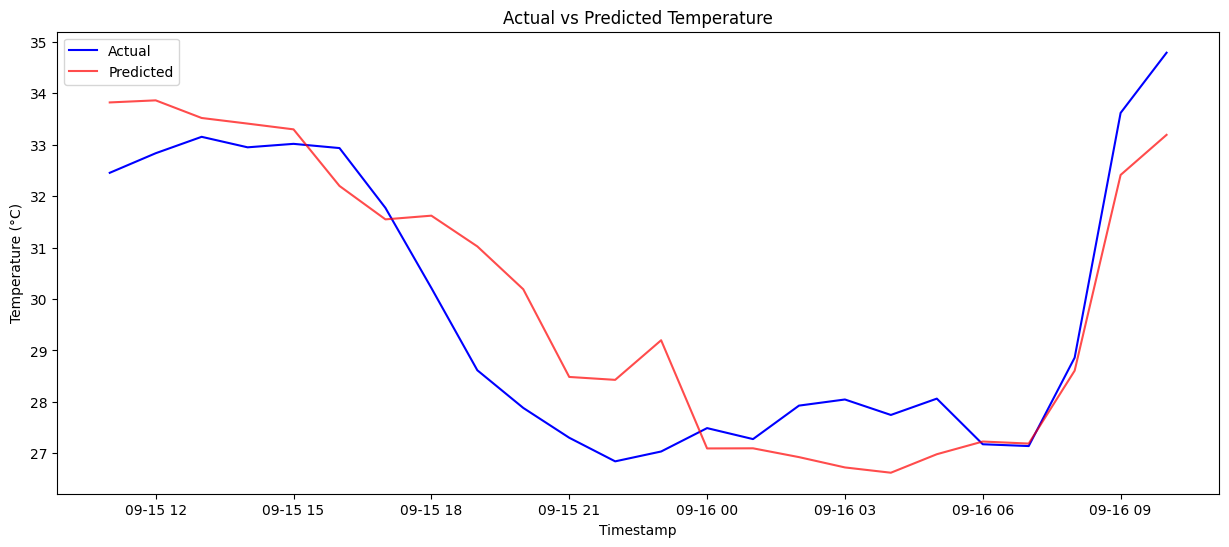

In [18]:
## merge data and predictions on timestamp
data_merged = pd.merge(data, predictions_db, on="timestamp", how="inner")
data_merged.sort_values("timestamp",ascending=False,inplace=True)
## plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(data_merged['timestamp'], data_merged['temperature'], label='Actual', color='b')
plt.plot(data_merged['timestamp'], data_merged['temp_prediction'], label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()


## Calculate metrics and smape
from sklearn.metrics import mean_absolute_error, mean_squared_error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
mae = mean_absolute_error(data_merged['temperature'], data_merged['temp_prediction'])
rmse = mean_squared_error(data_merged['temperature'], data_merged['temp_prediction'], squared=False)
smape_value = smape(data_merged['temperature'], data_merged['temp_prediction'])
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape_value:.2f}")

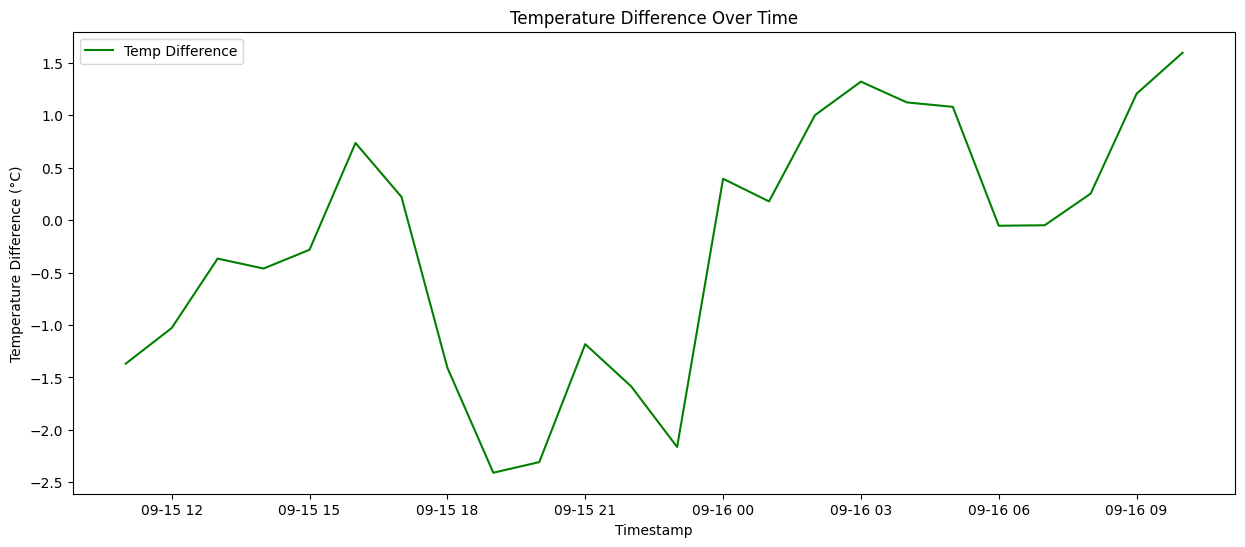

In [20]:
data_merged["temp_diff"] = data_merged["temperature"] - data_merged["temp_prediction"]
# plot temp_diff
plt.figure(figsize=(15, 6))
plt.plot(data_merged['timestamp'], data_merged['temp_diff'], label='Temp Difference', color='g')
plt.xlabel('Timestamp')
plt.ylabel('Temperature Difference (°C)')
plt.title('Temperature Difference Over Time')
plt.legend()
